#Unificación de los datos
Vanessa Rodríguez Horcajo

En este notebook se recogen todas las funciones definidas y pruebas ejecutadas para la unificación de los diferentes conjuntos de datos de los que se disponen en un único conjunto de datos que nos permita encontrar relaciones entre los mismos y dar respuesta a una serie de preguntas. Los conjuntos de datos a relacionar y unificar entre sí son:
  * C1: Conjunto de **datos meteorológicos** que propocinan información de las **condiciones ambientales del exterior del aula**. La obtención de este conjunto de datos se encuntra recogida en el notebook *Datos meteorológicos*.
  * C2: Conjunto de mediciones de las **motas sensoras del aula 3301** que propocinan información de las **condiciones de temperetura, humedad y luminosidad del interior del aula**. La obtención de este conjunto de datos se encuntra recogida en el notebook *Motas_3301*.
  * C3: Conjunto de mediciones de las **motas sensoras del aula 3304** que propocinan información de las **condiciones de temperetura, humedad y luminosidad del interior del aula**. La obtención de este conjunto de datos se encuntra recogida en el notebook *Motas_3304*.
  * C4: Conjunto de **respuestas de los cuestionarios** que propocinan información del **bienestar de los alumnos en el interior del aula en función de unas condiciones físicas y ambientales determinadas**. La obtención de este conjunto de datos se encuntra recogida en el notebook *Tratamiento_Cuestionarios*.

Todos estos conjuntos de datos se encuentran almacenados en Google Drive en formato csv.

Puesto que los cuatro conjuntos de datos a unificar presentan una periodicidad diferente, la unión de los mismos se realizará respetando la periodicidad mayor, es decir, la periodicidad de 2 horas que presentan las muestras de los cuestionarios de bienestar. Previamente a realizar esta unión de datos, se analizan estadísticamente los conjuntos de datos C1, C2 y C3 para conseguir más información acerca de las distintas variables que pueda resultar útil en el proceso de ajuste de periodicidad al que es necesario someterlas.

In [ ]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import sklearn.compose
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Funciones comunes

Función `normal_test`: función encargada de realizar los test de Shapiro-Wilk, Kolmogorov-Smirnov y Anderson-Darling para determinar la normalidad de la distribución de una variable. Recibe como parámetro la variable a evaluar.

In [ ]:
def normal_test(var):
  alpha = 0.05

  print("Prueba de Shapiro-Wilk")
  stat, p = stats.shapiro(var)
  print("\tEstadística de prueba:", stat)
  print("\tValor p:", p)
  if p > alpha:
    print("\tNo se puede rechazar la hipótesis nula (los datos parecen seguir una distribución normal)")
  else:
    print("\tSe rechaza la hipótesis nula (los datos no siguen una distribución normal)")

  print("\n\nPrueba de Kolmogorov-Smirnov")
  stat, p = stats.kstest(var, 'norm')
  alpha = 0.05
  print("\tEstadística de prueba:", stat)
  print("\tValor p:", p)
  if p > alpha:
    print("\tNo se puede rechazar la hipótesis nula (los datos parecen seguir una distribución normal)")
  else:
    print("\tSe rechaza la hipótesis nula (los datos no siguen una distribución normal)")

  print("\n\nPrueba de Anderson-Darling")
  result = stats.anderson(var)
  print("\tEstadística de prueba:", result.statistic)
  print("\tValores críticos:", result.critical_values)
  print("\tNiveles de significancia correspondientes:", result.significance_level)

  for i in range(len(result.critical_values)):
    if result.statistic < result.critical_values[i]:
        print("\tNo se puede rechazar la hipótesis nula (los datos parecen seguir una distribución normal) para un nivel de significancia de", result.significance_level[i])
        break
    elif i == len(result.critical_values) - 1:
        print("\tSe rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia")

## EDA_C1: Análisis exploratiorio del conjunto C1

In [ ]:
r_dm = "/content/drive/My Drive/TFM/Datos_Finales/InfoMet_Nov-Mar_T.csv"
df_dm = pd.read_csv(r_dm, sep=';', encoding='utf-8')
df_dm.head(1)

,Date,Time,Temperature,Humidity
0,01/11/2023,01:00,7.4,85.0


In [ ]:
df_dm.shape

(3648, 4)

In [ ]:
print(df_dm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3648 non-null   object 
 1   Time         3648 non-null   object 
 2   Temperature  3648 non-null   float64
 3   Humidity     3648 non-null   float64
dtypes: float64(2), object(2)
memory usage: 114.1+ KB
None


Las muestras de este conjunto de datos presentan una periodicidad de 1 hora. En primer lugar, se comprueba que no existen valores faltantes en el conjunto de datos. Tal y como puede observarse, no existen datos vacíos en el conjunto de datos.


In [ ]:
df_dm.isnull().sum().sort_values(ascending=True)

Date           0
Time           0
Temperature    0
Humidity       0
dtype: int64

A continuación, se realiza un análisis estadístico de cada una de las variables de Temperatura y Humedad.



array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>]], dtype=object)

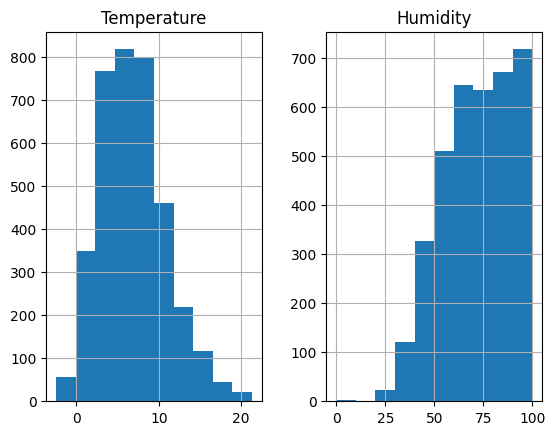

In [ ]:
df_dm.hist()

### Temperatura

Comenzando con la variable de temperatura, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
temp = df_dm['Temperature']
temp.describe()

count    3648.000000
mean        6.822944
std         3.965990
min        -2.500000
25%         3.900000
50%         6.500000
75%         9.100000
max        21.300000
Name: Temperature, dtype: float64

<Axes: ylabel='Density'>

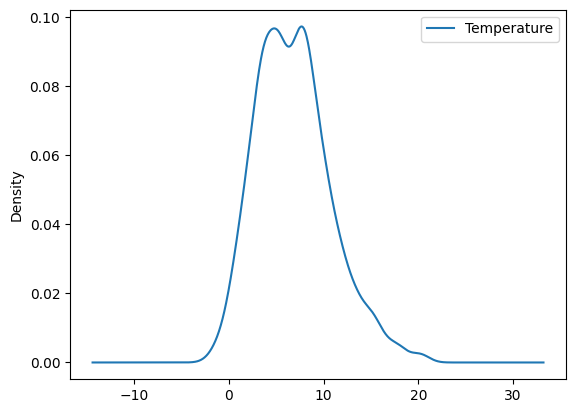

In [ ]:
df_dm[["Temperature"]].plot.kde()

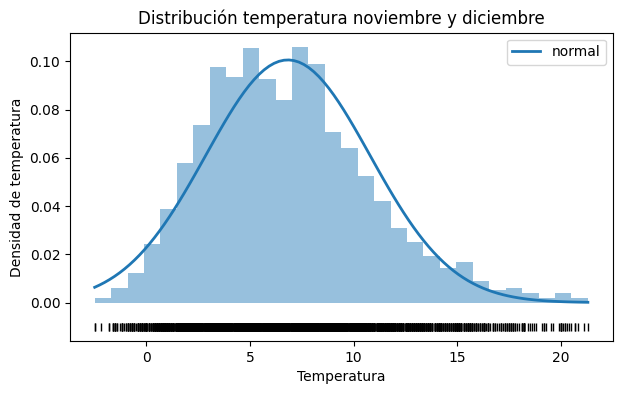

In [ ]:
mu, sigma = stats.norm.fit(temp)

x_hat = np.linspace(min(temp), max(temp), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=temp, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(temp, np.full_like(temp, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución temperatura noviembre y diciembre')
ax.set_xlabel('Temperatura')
ax.set_ylabel('Densidad de temperatura')
ax.legend();

En primera instancia, parece que la temperatura sigue una distribución normal. Se ejecutan los test de Shapiro-Wilk, Kolmogorov-Smirnov y Anderson-Darling para determinar la normalidad de la distribución de la variable.

In [ ]:
normal_test(temp)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9790669679641724
	Valor p: 8.691018801250482e-23
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 0.8830158963243491
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 15.631945469402126
	Valores críticos: [0.575 0.655 0.786 0.917 1.091]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Tras realizar los test de normalidad, se determina que la variable de temperatura no sigue una distribución normal.

### Humedad

Continuando con la variable de humedad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
hum = df_dm['Humidity']
hum.describe()

count    3648.000000
mean       71.452303
std        17.673995
min         0.000000
25%        58.000000
50%        72.000000
75%        87.000000
max       100.000000
Name: Humidity, dtype: float64

<Axes: ylabel='Density'>

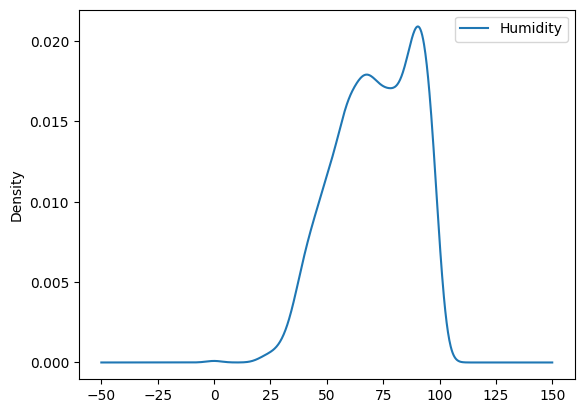

In [ ]:
df_dm[["Humidity"]].plot.kde()

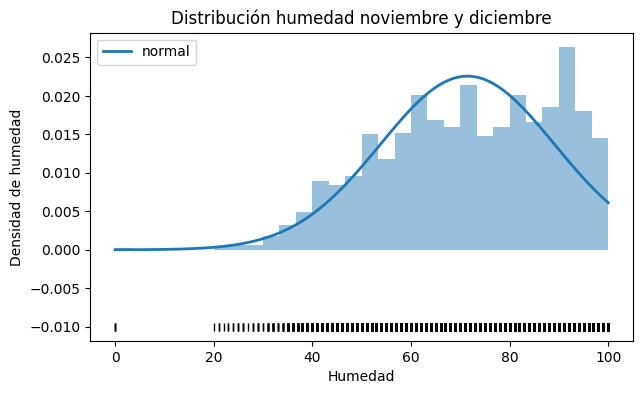

In [ ]:
mu, sigma = stats.norm.fit(hum)

x_hat = np.linspace(min(hum), max(hum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=hum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(hum, np.full_like(hum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución humedad noviembre y diciembre')
ax.set_xlabel('Humedad')
ax.set_ylabel('Densidad de humedad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(hum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9664957523345947
	Valor p: 2.4444983782344085e-28
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 0.9991776315789473
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 31.19830620771836
	Valores críticos: [0.575 0.655 0.786 0.917 1.091]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de humedad, como era de esperar por la representación gráfica anterior, tampoco sigue una distribución normal.

## EDA_C2: Análisis exploratiorio del conjunto C2

In [ ]:
r_dm3301 = "/content/drive/My Drive/TFM/Datos_Finales/Motas3301_data.csv"
df_dm3301 = pd.read_csv(r_dm3301, sep=';', encoding='utf-8')
df_dm3301.head(1)

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,01/11/2023,00:00,25.198536,46.745758,0.0,M1


In [ ]:
df_dm3301.shape

(60667, 6)

In [ ]:
print(df_dm3301.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60667 entries, 0 to 60666
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         60667 non-null  object 
 1   Time         60667 non-null  object 
 2   Temperature  60667 non-null  float64
 3   Humidity     60667 non-null  float64
 4   Luminosity   60667 non-null  float64
 5   Mota         60667 non-null  object 
dtypes: float64(3), object(3)
memory usage: 2.8+ MB
None


Las muestras de este conjunto de datos presentan una periodicidad de 5 minutos.En primer lugar, se comprueba que no existen valores faltantes en el conjunto de datos. Tal y como puede observarse, no existen datos vacíos en el conjunto de datos.

In [ ]:
df_dm3301.isnull().sum().sort_values(ascending=True)

Date           0
Time           0
Temperature    0
Humidity       0
Luminosity     0
Mota           0
dtype: int64

A continuación, se realiza un análisis estadístico de cada una de las variables de Temperatura, Humedad y Luminosidad. Puesto que este conjunto de datos almacena mediciones recogidas por dos motas sensoras diferentes, dicho estudio se realizará de manera independiente para los datos de cada mota.

In [ ]:
df_dm3301_m1 = df_dm3301[(df_dm3301['Mota'] == 'M1')]
df_dm3301_m2 = df_dm3301[(df_dm3301['Mota'] == 'M2')]

df_dm3301_m1.reset_index(drop=True, inplace=True)
df_dm3301_m2.reset_index(drop=True, inplace=True)


### Mota M1

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'Luminosity'}>, <Axes: >]], dtype=object)

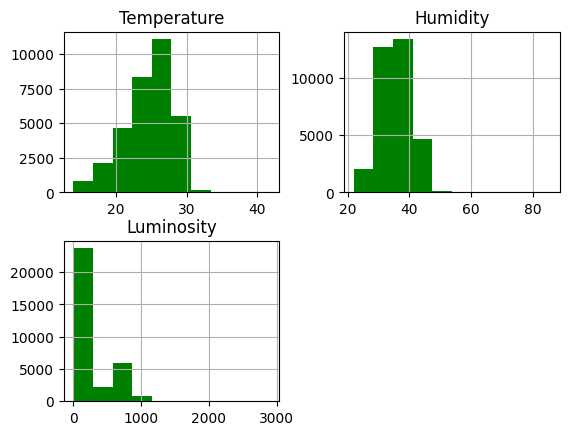

In [ ]:
df_dm3301_m1.hist(color = 'green')

#### Temperatura

Comenzando con la variable de temperatura. Puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
temp = df_dm3301_m1['Temperature']
temp.describe()

count    32814.000000
mean        24.597502
std          3.384034
min         13.921920
25%         22.561332
50%         25.181310
75%         27.041109
max         41.756950
Name: Temperature, dtype: float64

<Axes: ylabel='Density'>

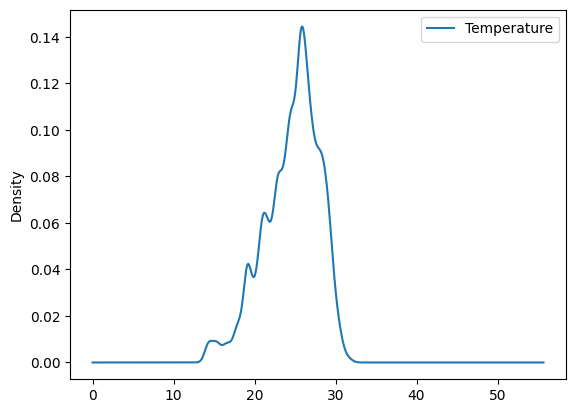

In [ ]:
df_dm3301_m1[["Temperature"]].plot.kde()

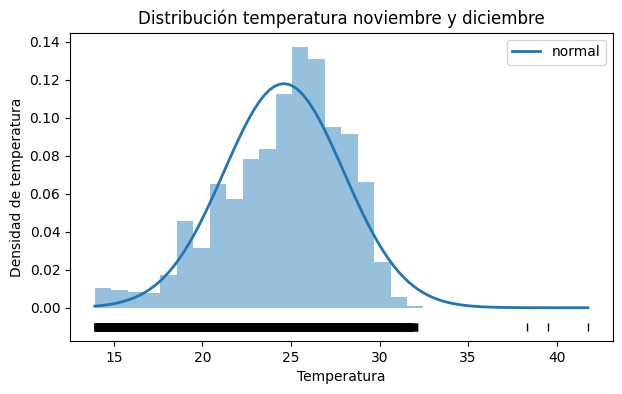

In [ ]:
mu, sigma = stats.norm.fit(temp)

x_hat = np.linspace(min(temp), max(temp), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=temp, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(temp, np.full_like(temp, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución temperatura noviembre y diciembre')
ax.set_xlabel('Temperatura')
ax.set_ylabel('Densidad de temperatura')
ax.legend();

A continuación, se ejecutan los test de Shapiro-Wilk, Kolmogorov-Smirnov y Anderson-Darling para determinar la normalidad de la distribución de la variable.

In [ ]:
normal_test(temp)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.968731164932251
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 263.0957796841976
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Tras realizar los test de normalidad, se determina que la variable de temperatura no sigue una distribución normal.

#### Humedad

Continuando con la variable de humedad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
hum = df_dm3301_m1['Humidity']
hum.describe()

count    32814.000000
mean        35.687937
std          4.858939
min         21.994019
25%         32.078029
50%         35.417226
75%         39.112912
max         85.514634
Name: Humidity, dtype: float64

<Axes: ylabel='Density'>

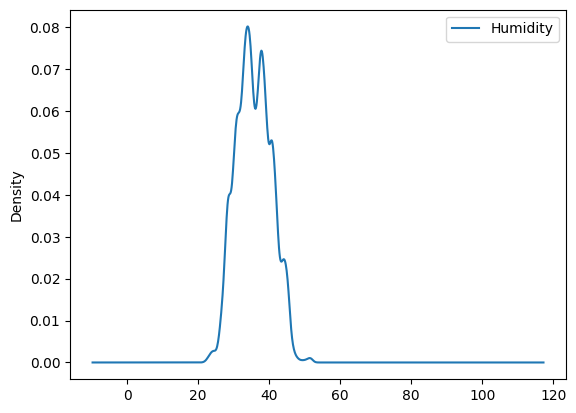

In [ ]:
df_dm3301_m1[["Humidity"]].plot.kde()

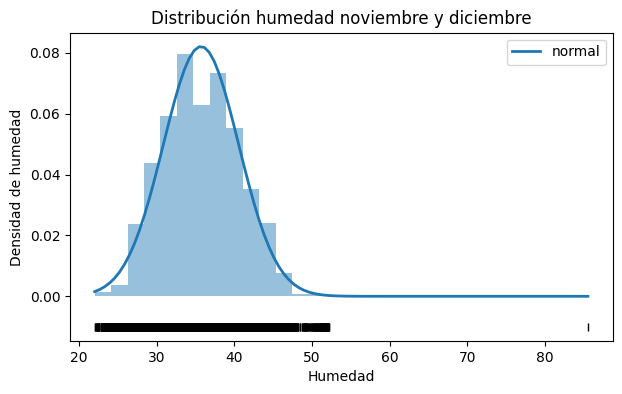

In [ ]:
mu, sigma = stats.norm.fit(hum)

x_hat = np.linspace(min(hum), max(hum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=hum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(hum, np.full_like(hum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución humedad noviembre y diciembre')
ax.set_xlabel('Humedad')
ax.set_ylabel('Densidad de humedad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(hum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9920375347137451
	Valor p: 4.884619842532318e-38
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 59.27263732458232
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de humedad tampoco sigue una distribución normal.

#### Luminosidad

Continuando con la variable de luminosidad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
lum = df_dm3301_m1['Luminosity']
lum.describe()

count    32814.000000
mean       214.469396
std        315.722138
min          0.000000
25%          0.000000
50%          0.000000
75%        366.296987
max       2895.567322
Name: Luminosity, dtype: float64

<Axes: ylabel='Density'>

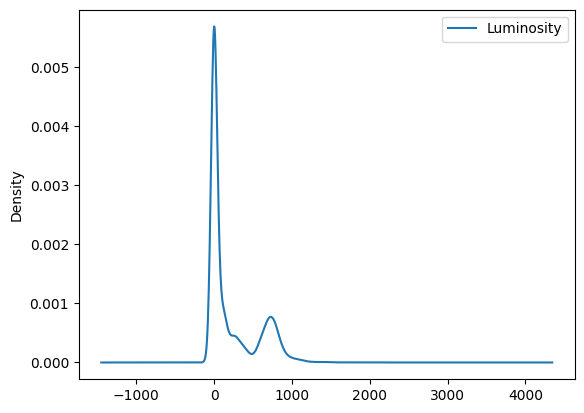

In [ ]:
df_dm3301_m1[["Luminosity"]].plot.kde()

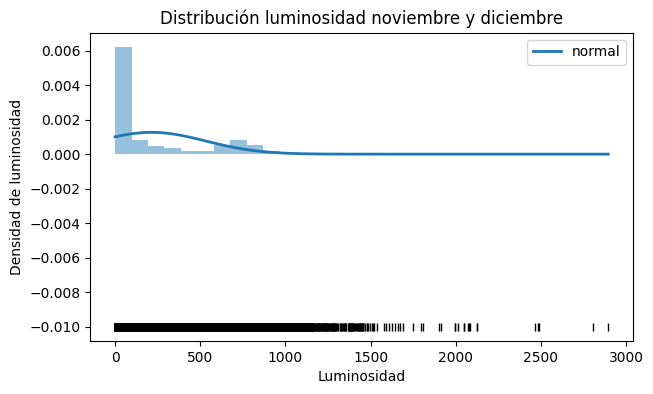

In [ ]:
mu, sigma = stats.norm.fit(lum)

x_hat = np.linspace(min(lum), max(lum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=lum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(lum, np.full_like(lum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución luminosidad noviembre y diciembre')
ax.set_xlabel('Luminosidad')
ax.set_ylabel('Densidad de luminosidad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(lum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.7113432884216309
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 0.5
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 4181.591762439188
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de luminosidad tampoco sigue una distribución normal.

### Mota M2

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'Luminosity'}>, <Axes: >]], dtype=object)

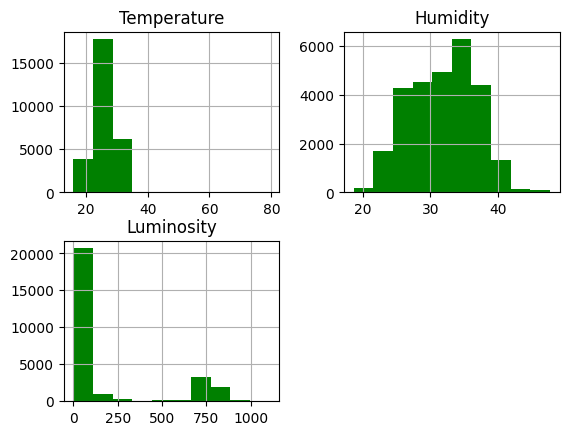

In [ ]:
df_dm3301_m2.hist(color = 'green')

#### Temperatura

Comenzando con la variable de temperatura. Puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
temp = df_dm3301_m2['Temperature']
temp.describe()

count    27853.000000
mean        26.181520
std          3.237559
min         16.006377
25%         24.327792
50%         26.807192
75%         28.481976
max         79.391406
Name: Temperature, dtype: float64

<Axes: ylabel='Density'>

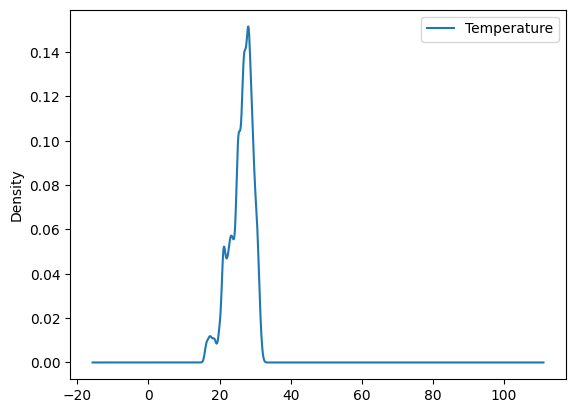

In [ ]:
df_dm3301_m2[["Temperature"]].plot.kde()

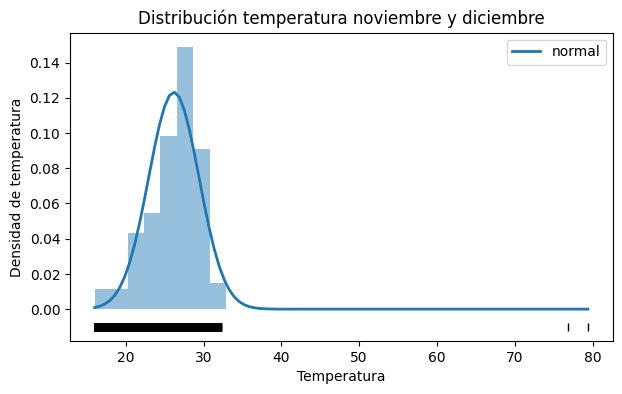

In [ ]:
mu, sigma = stats.norm.fit(temp)

x_hat = np.linspace(min(temp), max(temp), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=temp, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(temp, np.full_like(temp, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución temperatura noviembre y diciembre')
ax.set_xlabel('Temperatura')
ax.set_ylabel('Densidad de temperatura')
ax.legend();

A continuación, se ejecutan los test de Shapiro-Wilk, Kolmogorov-Smirnov y Anderson-Darling para determinar la normalidad de la distribución de la variable.

In [ ]:
normal_test(temp)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.942202627658844
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 373.23560154956795
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Tras realizar los test de normalidad, se determina que la variable de temperatura no sigue una distribución normal.

#### Humedad

Continuando con la variable de humedad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
hum = df_dm3301_m2['Humidity']
hum.describe()

count    27853.000000
mean        31.906795
std          4.822267
min         18.705877
25%         28.113149
50%         32.264659
75%         35.746104
max         47.650197
Name: Humidity, dtype: float64

<Axes: ylabel='Density'>

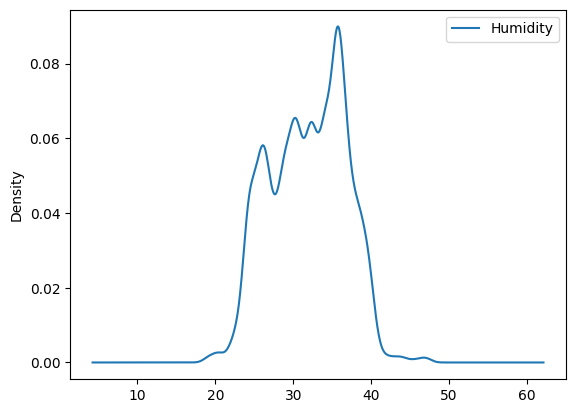

In [ ]:
df_dm3301_m2[["Humidity"]].plot.kde()

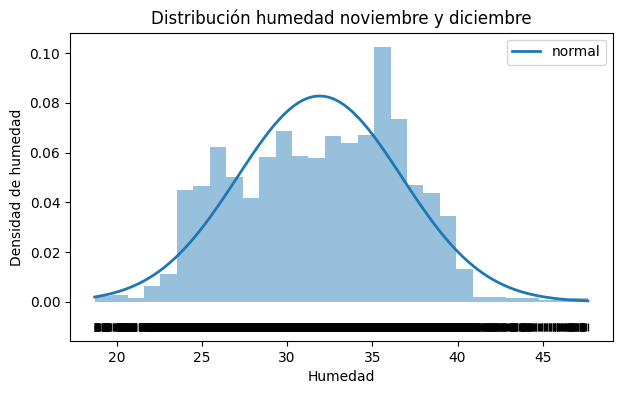

In [ ]:
mu, sigma = stats.norm.fit(hum)

x_hat = np.linspace(min(hum), max(hum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=hum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(hum, np.full_like(hum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución humedad noviembre y diciembre')
ax.set_xlabel('Humedad')
ax.set_ylabel('Densidad de humedad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(hum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9818412065505981
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 181.7523952336196
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de humedad tampoco sigue una distribución normal.

#### Luminosidad

Continuando con la variable de luminosidad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

In [ ]:
lum = df_dm3301_m2['Luminosity']
lum.describe()

count    27853.000000
mean       172.502336
std        303.949242
min          0.000000
25%          0.000000
50%          1.382400
75%        129.930239
max       1105.950700
Name: Luminosity, dtype: float64

<Axes: ylabel='Density'>

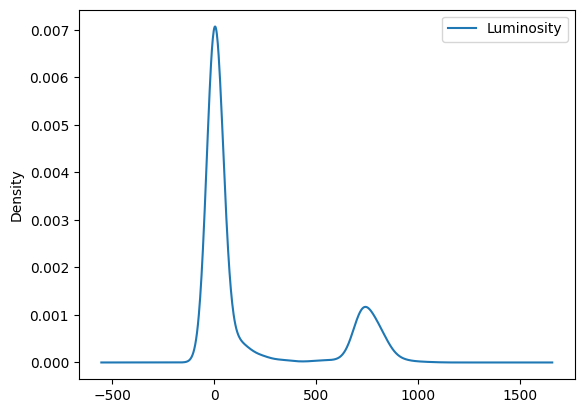

In [ ]:
df_dm3301_m2[["Luminosity"]].plot.kde()

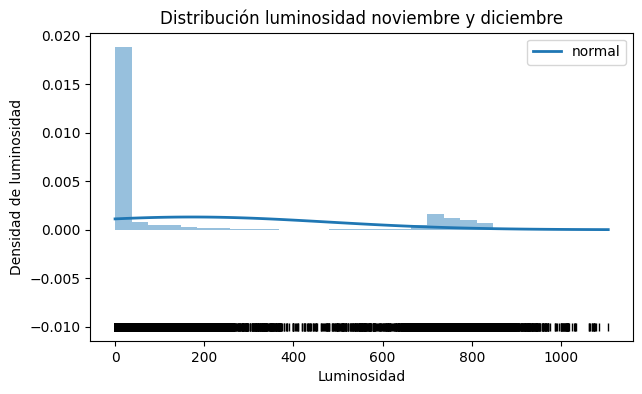

In [ ]:
mu, sigma = stats.norm.fit(lum)

x_hat = np.linspace(min(lum), max(lum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=lum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(lum, np.full_like(lum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución luminosidad noviembre y diciembre')
ax.set_xlabel('Luminosidad')
ax.set_ylabel('Densidad de luminosidad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(lum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.5879818201065063
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 0.5
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 5674.309990342044
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de luminosidad tampoco sigue una distribución normal.

## EDA_C3: Análisis exploratiorio del conjunto C3

In [ ]:
r_dm3304 = "/content/drive/My Drive/TFM/Datos_Finales/Motas3304_data.csv"
df_dm3304 = pd.read_csv(r_dm3304, sep=';', encoding='utf-8')
df_dm3304.head(1)

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,03/11/2023,08:53,20.6,47.1,73.33,M3


In [ ]:
df_dm3304.shape

(60529, 6)

In [ ]:
print(df_dm3304.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60529 entries, 0 to 60528
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         60529 non-null  object 
 1   Time         60529 non-null  object 
 2   Temperature  60529 non-null  float64
 3   Humidity     60529 non-null  float64
 4   Luminosity   60529 non-null  float64
 5   Mota         60529 non-null  object 
dtypes: float64(3), object(3)
memory usage: 2.8+ MB
None


Las muestras de este conjunto de datos presentan una periodicidad de 5 minutos.En primer lugar, se comprueba que no existen valores faltantes en el conjunto de datos. Tal y como puede observarse, no existen datos vacíos en el conjunto de datos.

In [ ]:
df_dm3304.isnull().sum().sort_values(ascending=True)

Date           0
Time           0
Temperature    0
Humidity       0
Luminosity     0
Mota           0
dtype: int64

A continuación, se realiza un análisis estadístico de cada una de las variables de Temperatura, Humedad y Luminosidad. Puesto que este conjunto de datos almacena mediciones recogidas por tres motas sensoras diferentes, dicho estudio se realizará de manera independiente para los datos de cada mota.

In [ ]:
df_dm3304_65793 = df_dm3304[(df_dm3304['Mota'] == 'M3')]
df_dm3304_131332 = df_dm3304[(df_dm3304['Mota'] == 'M2')]
df_dm3304_65794 = df_dm3304[(df_dm3304['Mota'] == 'M1')]

df_dm3304_65793.reset_index(drop=True, inplace=True)
df_dm3304_131332.reset_index(drop=True, inplace=True)
df_dm3304_65794.reset_index(drop=True, inplace=True)

### Mota 65793 (M3)

En primera instancia, parece que la variable de Humedad podría ajustarse a una distribución normal, pero es necesario un análisis en profundidad para poder afirmarlo.

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'Luminosity'}>, <Axes: >]], dtype=object)

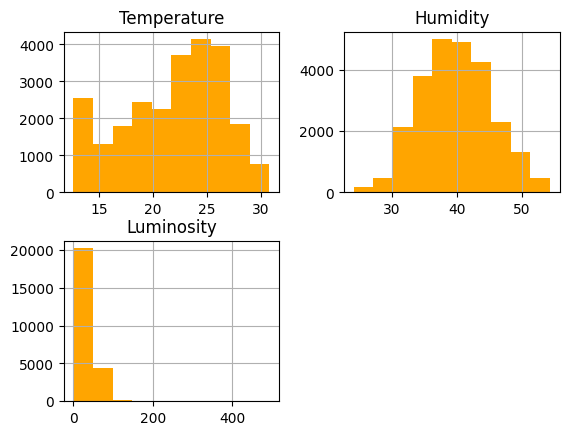

In [ ]:
df_dm3304_65793.hist(color = 'orange')

#### Temperatura

Comenzando con la variable de temperatura, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

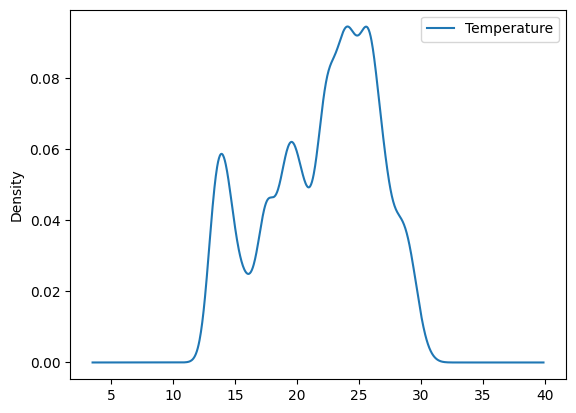

In [ ]:
df_dm3304_65793[["Temperature"]].plot.kde()

In [ ]:
temp = df_dm3304_65793['Temperature']
temp.describe()

count    24769.000000
mean        21.895825
std          4.530248
min         12.600000
25%         18.700000
50%         22.700000
75%         25.500000
max         30.800000
Name: Temperature, dtype: float64

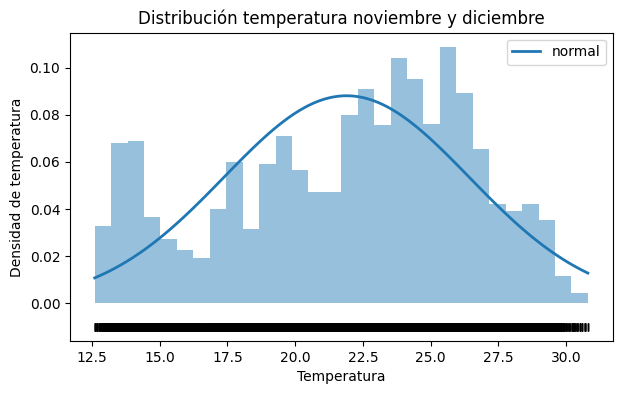

In [ ]:
mu, sigma = stats.norm.fit(temp)

x_hat = np.linspace(min(temp), max(temp), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=temp, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(temp, np.full_like(temp, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución temperatura noviembre y diciembre')
ax.set_xlabel('Temperatura')
ax.set_ylabel('Densidad de temperatura')
ax.legend();

A continuación, se ejecutan los test de Shapiro-Wilk, Kolmogorov-Smirnov y Anderson-Darling para determinar la normalidad de la distribución de la variable.

In [ ]:
normal_test(temp)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9557824730873108
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 318.88541589392116
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Tras realizar los test de normalidad, se determina que la variable de temperatura no sigue una distribución normal.

#### Humedad

Continuando con la variable de humedad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

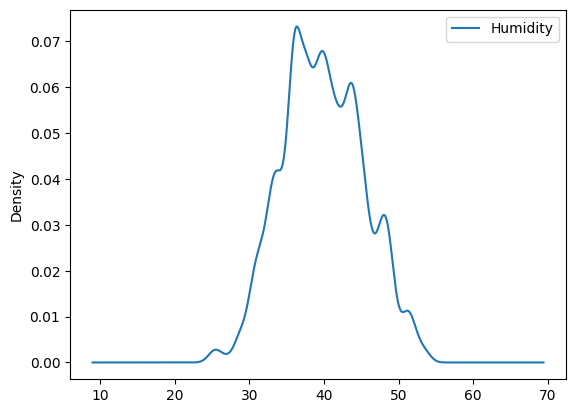

In [ ]:
df_dm3304_65793[["Humidity"]].plot.kde()

In [ ]:
hum = df_dm3304_65793['Humidity']
hum.describe()

count    24769.000000
mean        39.839348
std          5.421913
min         24.100000
25%         36.000000
50%         39.600000
75%         43.700000
max         54.300000
Name: Humidity, dtype: float64

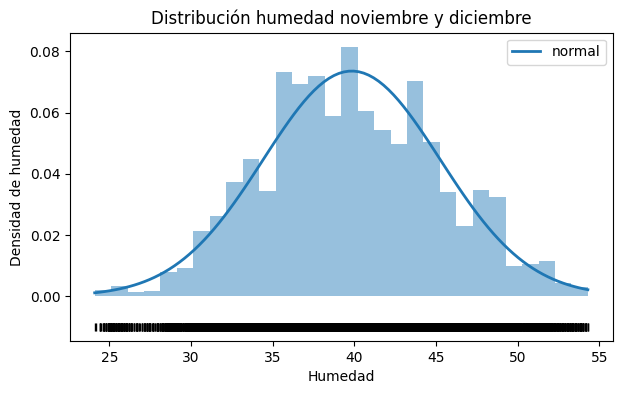

In [ ]:
mu, sigma = stats.norm.fit(hum)

x_hat = np.linspace(min(hum), max(hum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=hum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(hum, np.full_like(hum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución humedad noviembre y diciembre')
ax.set_xlabel('Humedad')
ax.set_ylabel('Densidad de humedad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(hum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9949834942817688
	Valor p: 6.717265682271093e-28
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 33.56882692838553
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de humedad tampoco sigue una distribución normal.

#### Luminosidad

Continuando con la variable de luminosidad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

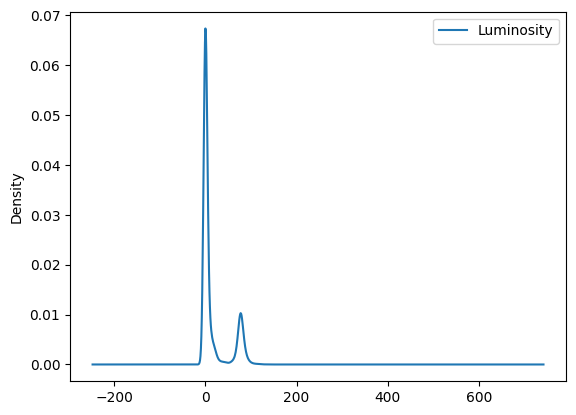

In [ ]:
df_dm3304_65793[["Luminosity"]].plot.kde()

In [ ]:
lum = df_dm3304_65793['Luminosity']
lum.describe()

count    24769.000000
mean        16.619395
std         30.145983
min          0.000000
25%          0.000000
50%          0.000000
75%         11.670000
max        494.170000
Name: Luminosity, dtype: float64

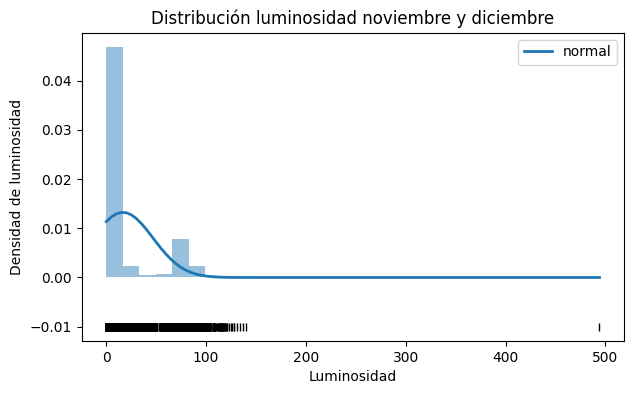

In [ ]:
mu, sigma = stats.norm.fit(lum)

x_hat = np.linspace(min(lum), max(lum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=lum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(lum, np.full_like(lum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución luminosidad noviembre y diciembre')
ax.set_xlabel('Luminosidad')
ax.set_ylabel('Densidad de luminosidad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(lum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.5864020586013794
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 0.5
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 4888.7140243684735
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de luminosidad tampoco sigue una distribución normal.

### Mota 131332 (M2)

En primera instancia, parece que las variables de Temperaura y Humedad podrían asemejarse a distribución normal, pero es necesario un análisis en profundidad para poder afirmarlo.

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'Luminosity'}>, <Axes: >]], dtype=object)

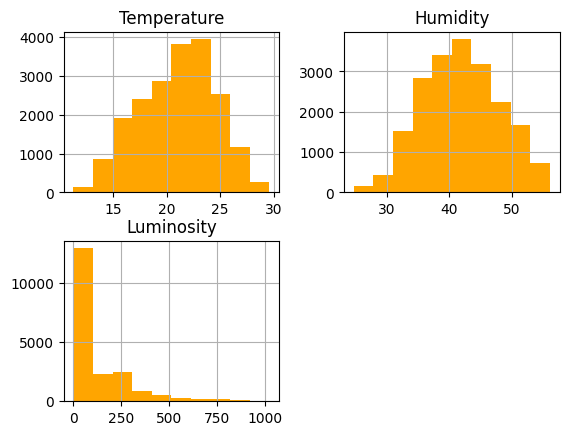

In [ ]:
df_dm3304_131332.hist(color = 'orange')

#### Temperatura

Comenzando con la variable de temperatura, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

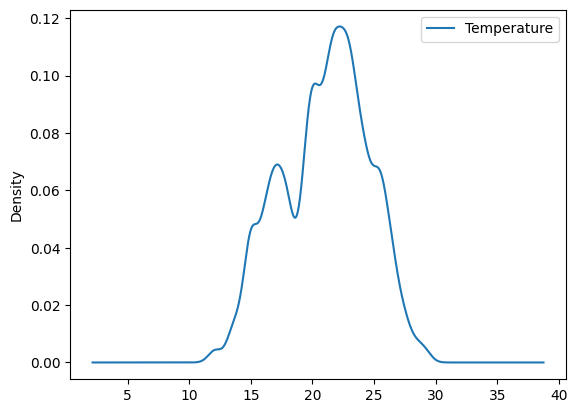

In [ ]:
df_dm3304_131332[["Temperature"]].plot.kde()

In [ ]:
temp = df_dm3304_131332['Temperature']
temp.describe()

count    19969.000000
mean        21.011353
std          3.536939
min         11.300000
25%         18.200000
50%         21.400000
75%         23.500000
max         29.600000
Name: Temperature, dtype: float64

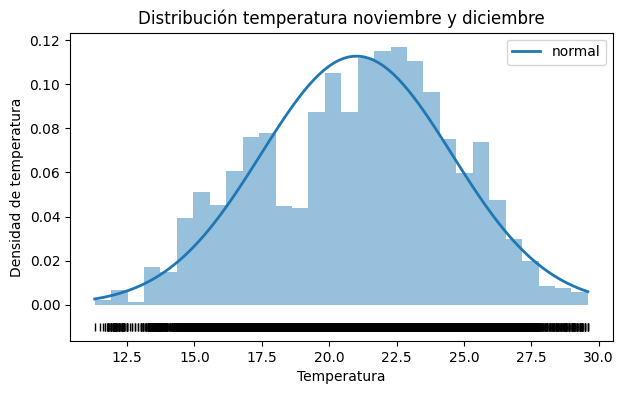

In [ ]:
mu, sigma = stats.norm.fit(temp)

x_hat = np.linspace(min(temp), max(temp), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=temp, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(temp, np.full_like(temp, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución temperatura noviembre y diciembre')
ax.set_xlabel('Temperatura')
ax.set_ylabel('Densidad de temperatura')
ax.legend();

A continuación, se ejecutan los test de Shapiro-Wilk, Kolmogorov-Smirnov y Anderson-Darling para determinar la normalidad de la distribución de la variable.

In [ ]:
normal_test(temp)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9860963225364685
	Valor p: 1.0931291099458963e-39
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 85.66701197497241
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Tras realizar los test de normalidad, se determina que la variable de temperatura no sigue una distribución normal.

#### Humedad

Continuando con la variable de humedad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

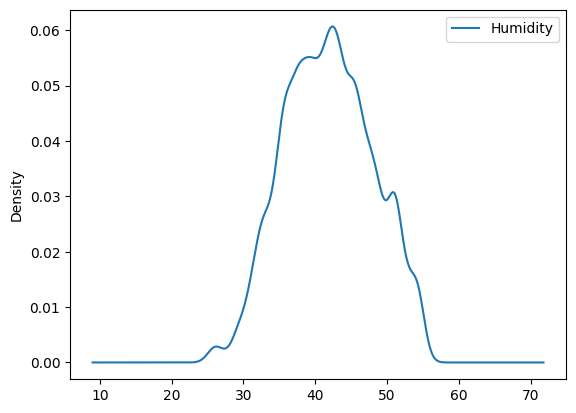

In [ ]:
df_dm3304_131332[["Humidity"]].plot.kde()

In [ ]:
hum = df_dm3304_131332['Humidity']
hum.describe()

count    19969.000000
mean        41.845240
std          6.160701
min         24.700000
25%         37.300000
50%         41.800000
75%         46.300000
max         56.100000
Name: Humidity, dtype: float64

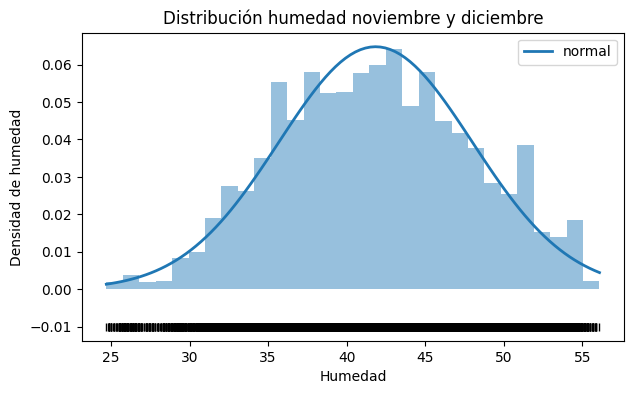

In [ ]:
mu, sigma = stats.norm.fit(hum)

x_hat = np.linspace(min(hum), max(hum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=hum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(hum, np.full_like(hum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución humedad noviembre y diciembre')
ax.set_xlabel('Humedad')
ax.set_ylabel('Densidad de humedad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(hum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9917621612548828
	Valor p: 5.964152707541073e-32
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 31.238545965949015
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de humedad tampoco sigue una distribución normal.

#### Luminosidad

Continuando con la variable de luminosidad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

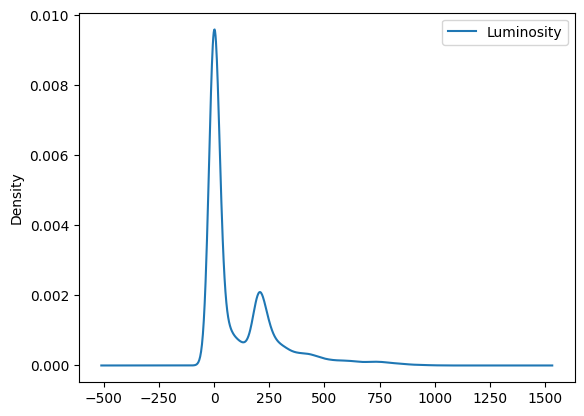

In [ ]:
df_dm3304_131332[["Luminosity"]].plot.kde()

In [ ]:
lum = df_dm3304_131332['Luminosity']
lum.describe()

count    19969.000000
mean       110.772339
std        170.634707
min          0.000000
25%          0.000000
50%          0.830000
75%        200.000000
max       1020.830000
Name: Luminosity, dtype: float64

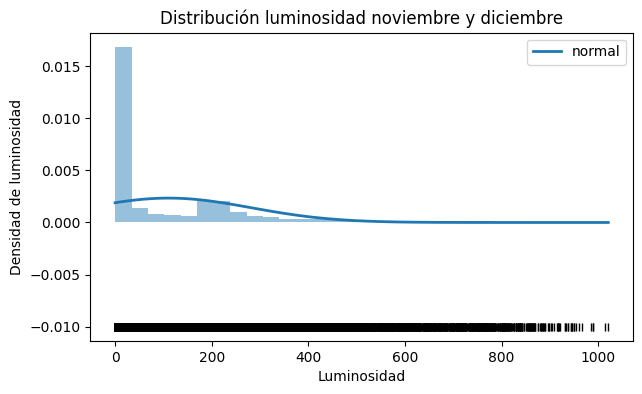

In [ ]:
mu, sigma = stats.norm.fit(lum)

x_hat = np.linspace(min(lum), max(lum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=lum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(lum, np.full_like(lum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución luminosidad noviembre y diciembre')
ax.set_xlabel('Luminosidad')
ax.set_ylabel('Densidad de luminosidad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(lum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.7029280662536621
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 0.5
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 2151.428295564143
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de luminosidad tampoco sigue una distribución normal.

### Mota 65794

En primera instancia, parece que las variables de Temperaura y Humedad podrían asemejarse a una distribución normal, pero es necesario un análisis en profundidad para poder afirmarlo.

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'Luminosity'}>, <Axes: >]], dtype=object)

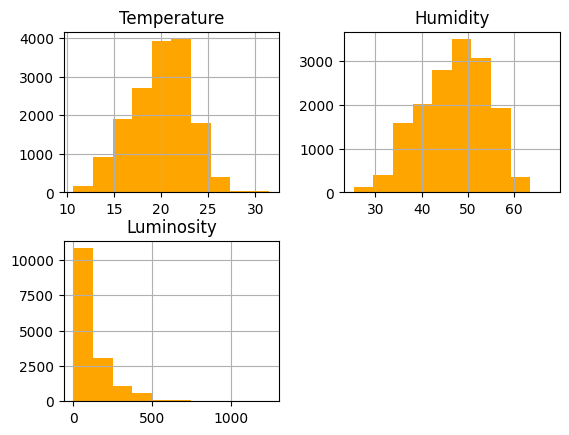

In [ ]:
df_dm3304_65794.hist(color = 'orange')

#### Temperatura

Comenzando con la variable de temperatura, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

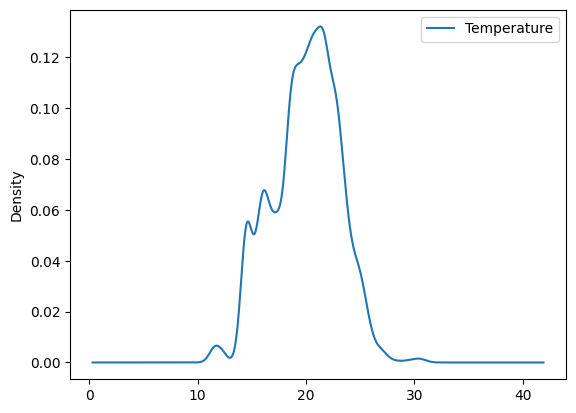

In [ ]:
df_dm3304_65794[["Temperature"]].plot.kde()

In [ ]:
temp = df_dm3304_65794['Temperature']
temp.describe()

count    15791.000000
mean        19.969077
std          3.070471
min         10.700000
25%         18.000000
50%         20.200000
75%         22.100000
max         31.500000
Name: Temperature, dtype: float64

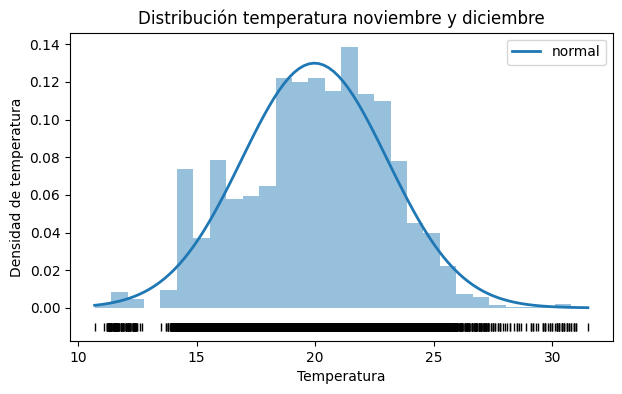

In [ ]:
mu, sigma = stats.norm.fit(temp)

x_hat = np.linspace(min(temp), max(temp), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=temp, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(temp, np.full_like(temp, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución temperatura noviembre y diciembre')
ax.set_xlabel('Temperatura')
ax.set_ylabel('Densidad de temperatura')
ax.legend();

A continuación, se ejecutan los test de Shapiro-Wilk, Kolmogorov-Smirnov y Anderson-Darling para determinar la normalidad de la distribución de la variable.

In [ ]:
normal_test(temp)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.9905405044555664
	Valor p: 7.657320664533286e-31
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 50.180554179358296
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Tras realizar los test de normalidad, se determina que la variable de temperatura no sigue una distribución normal.

#### Humedad

Continuando con la variable de humedad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

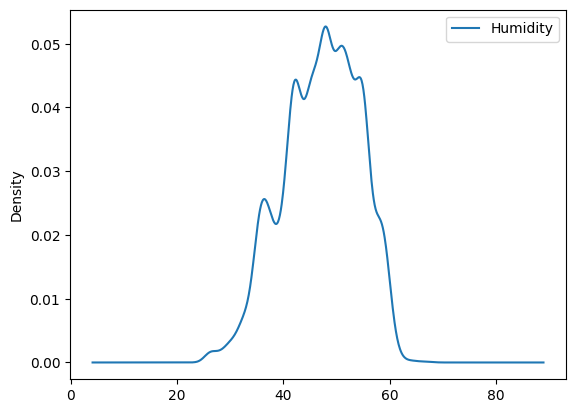

In [ ]:
df_dm3304_65794[["Humidity"]].plot.kde()

In [ ]:
hum = df_dm3304_65794['Humidity']
hum.describe()

count    15791.000000
mean        47.095928
std          7.148418
min         25.300000
25%         42.100000
50%         47.700000
75%         52.500000
max         67.700000
Name: Humidity, dtype: float64

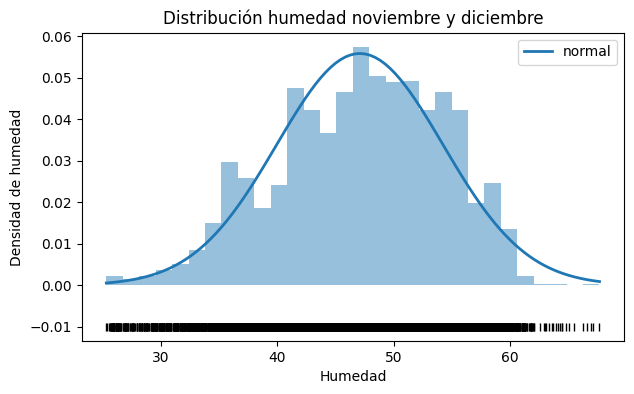

In [ ]:
mu, sigma = stats.norm.fit(hum)

x_hat = np.linspace(min(hum), max(hum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=hum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(hum, np.full_like(hum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución humedad noviembre y diciembre')
ax.set_xlabel('Humedad')
ax.set_ylabel('Densidad de humedad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(hum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.985865592956543
	Valor p: 1.4529446308428708e-36
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 1.0
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 54.530951471717344
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de humedad tampoco sigue una distribución normal.

#### Luminosidad

Continuando con la variable de luminosidad, puesto que se trata de una variable numérica la cual toma valores continuos, es posible representarla gráficamente y obtener información sobre la distribución a la que se ajustan estos valores.

<Axes: ylabel='Density'>

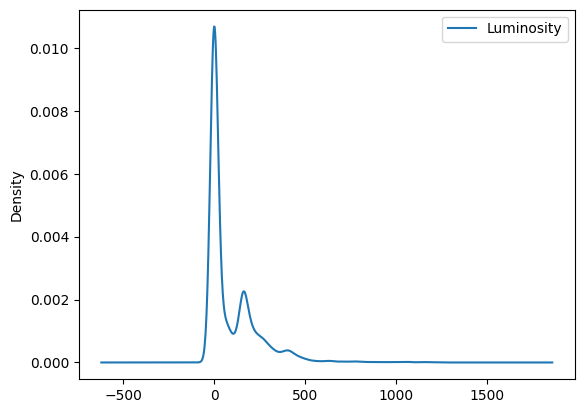

In [ ]:
df_dm3304_65794[["Luminosity"]].plot.kde()

In [ ]:
lum = df_dm3304_65794['Luminosity']
lum.describe()

count    15791.000000
mean        91.803097
std        148.015795
min          0.000000
25%          0.000000
50%          0.000000
75%        160.415000
max       1240.830000
Name: Luminosity, dtype: float64

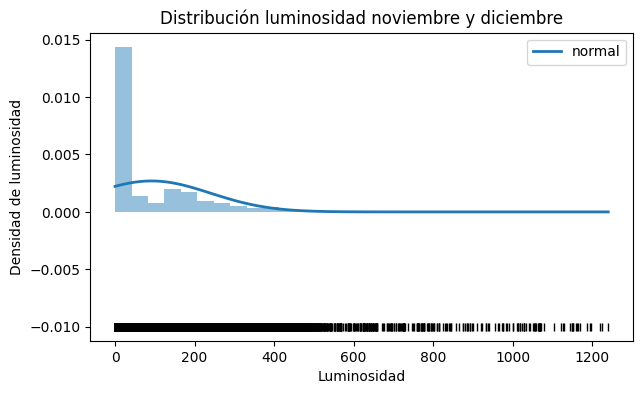

In [ ]:
mu, sigma = stats.norm.fit(lum)

x_hat = np.linspace(min(lum), max(lum), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=lum, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(lum, np.full_like(lum, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución luminosidad noviembre y diciembre')
ax.set_xlabel('Luminosidad')
ax.set_ylabel('Densidad de luminosidad')
ax.legend();

Ejecutemos los test de normalidad para determinar si la variable de humedad sigue una distribución normal.

In [ ]:
normal_test(lum)

Prueba de Shapiro-Wilk
	Estadística de prueba: 0.6720728874206543
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Kolmogorov-Smirnov
	Estadística de prueba: 0.5
	Valor p: 0.0
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal)


Prueba de Anderson-Darling
	Estadística de prueba: 1691.8300507240565
	Valores críticos: [0.576 0.656 0.787 0.918 1.092]
	Niveles de significancia correspondientes: [15.  10.   5.   2.5  1. ]
	Se rechaza la hipótesis nula (los datos no siguen una distribución normal) para todos los niveles de significancia


Se determina que la variable de luminosidad tampoco sigue una distribución normal.

## Unificación de los datos: C1 + C2 + C3 + C4

El conjunto de datos final estará contenido en el DataFrame `final_data`.

In [ ]:
final_data = pd.DataFrame()

### final_data() + C4

El conjunto de datos C4, que representa el conjunto de respuestas de los cuestionarios de bienestar, se encuentra dividido en 4 subconjuntos diferentes en función del aula y grupo al que pertenecen. En primer lugar, se realizará la unificación de estos 4 subconjuntos añadiendo dos nuevas columnas a las ya existentes que representen el aula y el grupo para no perder la trazabilidad de los datos y seguir permitiendo esta distinción entre aulas y grupos diferentes.

In [ ]:
r_dmc1m = "/content/drive/My Drive/TFM/Datos_Finales/3301M.csv"
r_dmc1t = "/content/drive/My Drive/TFM/Datos_Finales/3301T.csv"
r_dmc4m = "/content/drive/My Drive/TFM/Datos_Finales/3304M.csv"
r_dmc4t = "/content/drive/My Drive/TFM/Datos_Finales/3304T.csv"

df_dm1m = pd.read_csv(r_dmc1m, sep=';', encoding='utf-8')
df_dm1t = pd.read_csv(r_dmc1t, sep=';', encoding='utf-8')
df_dm4m = pd.read_csv(r_dmc4m, sep=';', encoding='utf-8')
df_dm4t = pd.read_csv(r_dmc4t, sep=';', encoding='utf-8')

In [ ]:
df_dm1m.head(1)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico
0,2023-11-08,9:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño


In [ ]:
df_dm1t.head(1)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico
0,2023-11-06,19:00:00,21:00:00,M1,"Quinta fila, lado izquierdo, segundo asiento d...",No,3,5,5,No,Sí,No,4,2,2,4,De acuerdo,Normal;Cansado,De acuerdo,Agotado/a;Enfermo/a;Con dolor de cuello;Con do...


In [ ]:
df_dm4m.head(1)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico
0,2023-11-07,9:00:00,11:00:00,M1,"Quinta fila, lado derecho",No,4.0,5,4,No,No,No,5,3,4,4,De acuerdo,Normal,Totalmente de acuerdo,Normal


In [ ]:
df_dm4t.head(1)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico
0,2023-11-06,17:00:00,19:00:00,M2,5008 04 9(1 era fila izquierda),No,3,5,4,No,No,Parcialmente,4,4,4,4,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal


In [ ]:
df_dm1m['Aula'] = '3301'
df_dm1t['Aula'] = '3301'
df_dm4m['Aula'] = '3304'
df_dm4t['Aula'] = '3304'

In [ ]:
df_dm1m['Grupo'] = 'M'
df_dm1t['Grupo'] = 'T'
df_dm4m['Grupo'] = 'M'
df_dm4t['Grupo'] = 'T'

In [ ]:
df_dm1m_col = df_dm1m.columns
df_dm1t_col = df_dm1t.columns
df_dm4m_col = df_dm4m.columns
df_dm4t_col = df_dm4t.columns

In [ ]:
if sorted(df_dm1m_col) == sorted(df_dm1t_col) == sorted(df_dm4m_col) == sorted(df_dm4t_col):
    print("Los cuatro conjuntos de datos contienen las mismas columnas.")
else:
    print("Los cuatro conjuntos de datos no contienen las mismas columnas.")

Los cuatro conjuntos de datos contienen las mismas columnas.


In [ ]:
print(f'El conjunto de datos del aula 3301 del grupo de mañana tiene {df_dm1m.shape[0]} filas y {df_dm1m.shape[1]} columnas')
print(f'El conjunto de datos del aula 3301 del grupo de tarde tiene {df_dm1t.shape[0]} filas y {df_dm1t.shape[1]} columnas')
print(f'El conjunto de datos del aula 3304 del grupo de mañana tiene {df_dm4m.shape[0]} filas y {df_dm4m.shape[1]} columnas')
print(f'El conjunto de datos del aula 3304 del grupo de tarde tiene {df_dm4t.shape[0]} filas y {df_dm4t.shape[1]} columnas\n')
suma_filas = df_dm1m.shape[0] + df_dm1t.shape[0] + df_dm4m.shape[0] + df_dm4t.shape[0]
print(f'El conjunto de datos resultante de unificar estos conjuntos de datos debería tener {suma_filas} filas y 24 columnas')

El conjunto de datos del aula 3301 del grupo de mañana tiene 524 filas y 22 columnas
El conjunto de datos del aula 3301 del grupo de tarde tiene 82 filas y 22 columnas
El conjunto de datos del aula 3304 del grupo de mañana tiene 285 filas y 22 columnas
El conjunto de datos del aula 3304 del grupo de tarde tiene 104 filas y 22 columnas

El conjunto de datos resultante de unificar estos conjuntos de datos debería tener 995 filas y 24 columnas


In [ ]:
final_data = pd.concat([df_dm1m, df_dm1t, df_dm4m, df_dm4t], axis=0)
print(f'El conjunto de datos resultante de unificar estos conjuntos de datos está formado por {final_data.shape[0]} filas y 24 columnas')

El conjunto de datos resultante de unificar estos conjuntos de datos está formado por 995 filas y 24 columnas


In [ ]:
final_data.reset_index(drop=True, inplace=True)

Verificamos que el conjunto de datos no tenga valores faltantes. Tal y como puede observarse, existen tres filas con valor nulo en la variable *Cortinas_abiertas*

In [ ]:
filas_con_nulos = final_data[final_data.isna().any(axis=1)]
filas_con_nulos

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo
291,2023-12-01,9:00:00,11:00:00,M1,Primera fila izquierda,No,NaN,3,5,No,Sí,Parcialmente,5,5,3,5,Totalmente de acuerdo,Motivado;Contento;Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M
432,2024-02-22,9:00:00,11:00:00,M1,5001 01 8,No,NaN,5,4,No,Sí,Parcialmente,4,4,5,4,De acuerdo,Normal,De acuerdo,Normal,3301,M
733,2023-11-22,11:00:00,13:00:00,M1,5008-04-29,No,NaN,5,4,No,No,No,4,4,4,4,De acuerdo,Normal;Con Ansiedad;Dormido,De acuerdo,Normal;Agotado/a;Con sueño,3304,M


En este momento, es necesario tomar una decisión: eliminar las muestras o rellenarlas de alguna manera. Teniendo en cuenta que no disponemos de un número considerable de muestras, la alternativa de eliminar estas dos muestras no se contempla como opción viable. De esta manera, es necesario decidir cómo van a rellenarse estos datos.


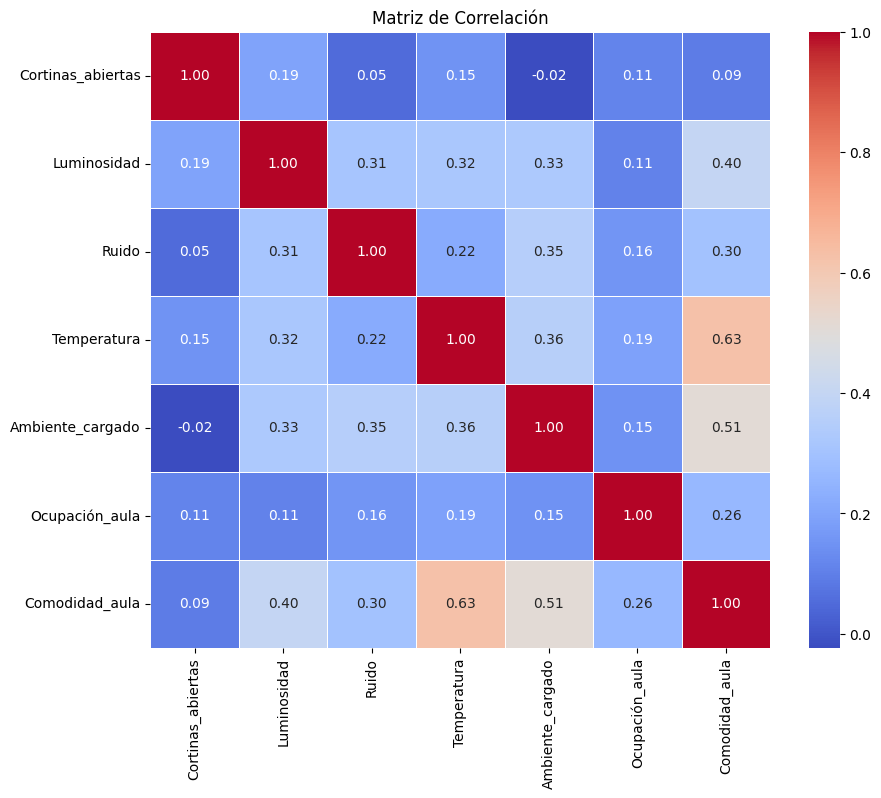

In [ ]:
columnas_numericas = final_data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = columnas_numericas.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Matriz de Correlación')
plt.show()

Tal y como puede observarse, la variable de *Cortinas_abiertas* no presenta una relación elevada con ninguna de las otras variables. Se ha decidido que se empleará la variable *Luminosidad*, que es con la que guarda mayor relación, para rellenar esos valores faltantes. Se seleccionarán las muestras del mismo aula y grupo que presenten la misma luminosidad que las muestras con datos vacíos y se rellenarán dichos datos con el valor más repetido (moda) entre las muestras con la misma luminosidad.

Primer caso: Luminosidad 3 y aula 3301

In [ ]:
lum_3 = final_data[(final_data['Luminosidad'] == 3) & (final_data['Aula'] == '3301') & (final_data['Grupo'] == 'M')]
lum_3 = lum_3.dropna()
lum_3['Cortinas_abiertas'].describe()

count    45.000000
mean      3.177778
std       0.386646
min       3.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Cortinas_abiertas, dtype: float64

In [ ]:
lum_3['Cortinas_abiertas'].mode()

0    3.0
Name: Cortinas_abiertas, dtype: float64

Segundo caso: Luminosidad 5 y aula 3301

In [ ]:
lum_5 = final_data[(final_data['Luminosidad'] == 5) & (final_data['Aula'] == '3301') & (final_data['Grupo'] == 'M')]
lum_5['Cortinas_abiertas'].describe()

count    392.000000
mean       3.971939
std        0.862239
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Cortinas_abiertas, dtype: float64

In [ ]:
lum_5['Cortinas_abiertas'].mode()

0    4.0
Name: Cortinas_abiertas, dtype: float64

Tercer caso: luminosidad 5 y aula 3304

In [ ]:
lum_5 = final_data[(final_data['Luminosidad'] == 5) & (final_data['Aula'] == '3304') & (final_data['Grupo'] == 'M')]
lum_5['Cortinas_abiertas'].describe()

count    162.000000
mean       3.358025
std        1.084145
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cortinas_abiertas, dtype: float64

In [ ]:
lum_5['Cortinas_abiertas'].mode()

0    4.0
Name: Cortinas_abiertas, dtype: float64

Tras los resultados obtenidos, se determina que las muestras faltantes serán rellenadas con el valor 3 si la luminosidad es 3 y con el valor 4 si la luminosidad es 5.


In [ ]:
lum3_3301m = final_data[(final_data['Luminosidad'] == 3) & (final_data['Aula'] == '3301') & (final_data['Grupo'] == 'M') & (final_data['Cortinas_abiertas'].isnull())]
final_data.loc[lum3_3301m.index] = lum3_3301m.fillna(3)

In [ ]:
lum5_3301m = final_data[(final_data['Luminosidad'] == 5) & (final_data['Aula'] == '3301') & (final_data['Grupo'] == 'M') & (final_data['Cortinas_abiertas'].isnull())]
final_data.loc[lum5_3301m.index] = lum5_3301m.fillna(4)

In [ ]:
lum5_3304m = final_data[(final_data['Luminosidad'] == 5) & (final_data['Aula'] == '3304') & (final_data['Grupo'] == 'M') & (final_data['Cortinas_abiertas'].isnull())]
final_data.loc[lum5_3304m.index] = lum5_3304m.fillna(4)

In [ ]:
filas_con_nulos = final_data[final_data.isna().any(axis=1)]
filas_con_nulos

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo


Es importante conocer el rango de fechas para las cuales se dispone de información. Este rango de fecha se deberá tener en cuenta a la hora de unificar los distintos conjuntos de datos.

In [ ]:
type(final_data['Date'][0])

str

In [ ]:
final_data['Date'] = pd.to_datetime(final_data['Date'], format='%Y-%m-%d')
final_data['Date'] = final_data['Date'].dt.strftime('%d/%m/%Y')
final_data['Date'] = pd.to_datetime(final_data['Date'], format='%d/%m/%Y')

In [ ]:
type(final_data['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
fechas = sorted(final_data['Date'].unique().tolist())
fechas

[Timestamp('2023-11-06 00:00:00'),
 Timestamp('2023-11-07 00:00:00'),
 Timestamp('2023-11-08 00:00:00'),
 Timestamp('2023-11-09 00:00:00'),
 Timestamp('2023-11-10 00:00:00'),
 Timestamp('2023-11-13 00:00:00'),
 Timestamp('2023-11-14 00:00:00'),
 Timestamp('2023-11-15 00:00:00'),
 Timestamp('2023-11-16 00:00:00'),
 Timestamp('2023-11-17 00:00:00'),
 Timestamp('2023-11-20 00:00:00'),
 Timestamp('2023-11-21 00:00:00'),
 Timestamp('2023-11-22 00:00:00'),
 Timestamp('2023-11-23 00:00:00'),
 Timestamp('2023-11-24 00:00:00'),
 Timestamp('2023-11-27 00:00:00'),
 Timestamp('2023-11-28 00:00:00'),
 Timestamp('2023-11-29 00:00:00'),
 Timestamp('2023-11-30 00:00:00'),
 Timestamp('2023-12-01 00:00:00'),
 Timestamp('2023-12-04 00:00:00'),
 Timestamp('2023-12-05 00:00:00'),
 Timestamp('2023-12-11 00:00:00'),
 Timestamp('2023-12-12 00:00:00'),
 Timestamp('2023-12-13 00:00:00'),
 Timestamp('2023-12-14 00:00:00'),
 Timestamp('2023-12-15 00:00:00'),
 Timestamp('2023-12-19 00:00:00'),
 Timestamp('2023-12-

Tal y como puede observarse, se dipone de datos desde el 6 de noviembre de 2023 hasta el 22 de marzo de 2024.

In [ ]:
final_data.shape

(995, 22)

### final_data(C4) + C1

El conjunto de datos C1, que contiene los datos meteorológicos, presenta una periodicidad de 1 hora. Sin embargo, tal y como ya se ha comentado, se ha decidido fijar la periodicidad a 2 horas puesto que cada uno de los cuestionarios de bienestar recoge datos para una franja de 2 horas. Analicemos los datos y determinemos si se produce una variación significativa de temperatura y humedad exterior entre las horas de inicio, mitad y final de las franjas de 2 horas.




In [ ]:
horas_concretas_m1 = ["09:00", "10:00", "11:00"]
horas_concretas_m2 = ["11:00", "12:00", "13:00"]
horas_concretas_m3 = ["13:00", "14:00", "15:00"]

horas_concretas_t1 = ["15:00", "16:00", "17:00"]
horas_concretas_t2 = ["17:00", "18:00", "19:00"]
horas_concretas_t3 = ["19:00", "20:00", "21:00"]

h_mañana1 = df_dm[df_dm['Time'].isin(horas_concretas_m1)]
h_mañana2 = df_dm[df_dm['Time'].isin(horas_concretas_m2)]
h_mañana3 = df_dm[df_dm['Time'].isin(horas_concretas_m3)]

h_mañana1.reset_index(drop=True, inplace=True)
h_mañana2.reset_index(drop=True, inplace=True)
h_mañana3.reset_index(drop=True, inplace=True)

h_tarde1 = df_dm[df_dm['Time'].isin(horas_concretas_t1)]
h_tarde2 = df_dm[df_dm['Time'].isin(horas_concretas_t2)]
h_tarde3 = df_dm[df_dm['Time'].isin(horas_concretas_t3)]

h_tarde1.reset_index(drop=True, inplace=True)
h_tarde2.reset_index(drop=True, inplace=True)
h_tarde3.reset_index(drop=True, inplace=True)

##### Comprobación de resultados

In [ ]:
h_mañana1.shape

(456, 4)

In [ ]:
h_mañana1['Time'].unique()

array(['09:00', '10:00', '11:00'], dtype=object)

In [ ]:
h_mañana2.shape

(456, 4)

In [ ]:
h_mañana2['Time'].unique()

array(['11:00', '12:00', '13:00'], dtype=object)

In [ ]:
h_mañana3.shape

(456, 4)

In [ ]:
h_mañana3['Time'].unique()

array(['13:00', '14:00', '15:00'], dtype=object)

In [ ]:
h_tarde1.shape

(456, 4)

In [ ]:
h_tarde1['Time'].unique()

array(['15:00', '16:00', '17:00'], dtype=object)

In [ ]:
h_tarde2.shape

(456, 4)

In [ ]:
h_tarde2['Time'].unique()

array(['17:00', '18:00', '19:00'], dtype=object)

In [ ]:
h_tarde3.shape

(456, 4)

In [ ]:
h_tarde2['Time'].unique()

array(['17:00', '18:00', '19:00'], dtype=object)

#### Comprobación de la variación de temperatura y humedad

Función `variación`: función en cargada de calcular las variaciones de la variable *var* que recibe como parámetro para cada una de las franjas indicadas: hora inicio-hora media, hora media-hora final, hora inicio-hora final. Devuelve un DataFrame con los resultados obtenidos.

In [ ]:
def variacion(dataframe, hi, hm, hf, var):

  diferencias = []

  for i in range(0, len(dataframe), 3):
    temp_I = dataframe.iloc[i][var]
    temp_M = dataframe.iloc[i + 1][var]
    temp_F = dataframe.iloc[i + 2][var]

    diferencia_I_M = abs(temp_M - temp_I)
    diferencia_I_F = abs(temp_F - temp_I)
    diferencia_M_F = abs(temp_F - temp_M)

    d1 = 'Diferencia '+ hi + '-' + hm
    d2 = 'Diferencia '+ hi + '-' + hf
    d3 = 'Diferencia '+ hm + '-' + hf

    diferencias.append({'Date': dataframe.iloc[i]['Date'], d1: diferencia_I_M, d2 : diferencia_I_F , d3 : diferencia_M_F})

  df_diferencias = pd.DataFrame(diferencias)


  return df_diferencias

Función `pintar_variación_media`: función encargada de la representación visual de la variación media de la variable *var* para cada una de las franjas de dos horas establecidas.

In [ ]:
def pintar_variacion_media(df1, df2, df3, var, hi, hf):

  l_h = []
  for hora in range(hi, hf+1):
    l_h.append(f"{hora:02d}:00")


  l1 = [df1.iloc[:, 1].mean(), df1.iloc[:, 3].mean(), df1.iloc[:, 2].mean()]
  l2 = [df2.iloc[:, 1].mean(), df2.iloc[:, 3].mean(), df2.iloc[:, 2].mean()]
  l3 = [df3.iloc[:, 1].mean(), df3.iloc[:, 3].mean(), df3.iloc[:, 2].mean()]
  eje_x1 = [l_h[0]+'-'+l_h[1], l_h[1]+'-'+l_h[2], l_h[0]+'-'+l_h[2]]
  eje_x2 = [l_h[2]+'-'+l_h[3], l_h[3]+'-'+l_h[4], l_h[2]+'-'+l_h[4]]
  eje_x3 = [l_h[4]+'-'+l_h[5], l_h[5]+'-'+l_h[6], l_h[4]+'-'+l_h[6]]

  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  axs[0].plot(l1)
  t1= 'Variación media de '+ var+ '\nentre la hora de inicio y hora media de la franja de 2 horas'
  axs[0].set_title(t1)
  axs[0].set_ylabel('Media de variación')
  axs[0].set_xticks(range(3))
  axs[0].set_xticklabels(eje_x1)

  axs[1].plot(l2)
  t2= 'Variación media de '+ var+ '\nentre la hora media y hora de fin de la franja de 2 horas'
  axs[1].set_title(t2)
  axs[1].set_ylabel('Media de variación')
  axs[1].set_xticks(range(3))
  axs[1].set_xticklabels(eje_x2)

  axs[2].plot(l3)
  t3= 'Variación media de '+ var+ '\nentre la hora de inicio y hora de fin de la franja de 2 horas'
  axs[2].set_title(t3)
  axs[2].set_ylabel('Media de variación')
  axs[2].set_xticks(range(3))
  axs[2].set_xticklabels(eje_x3)


  plt.tight_layout()
  plt.show()

##### Temperatura horario mañana

###### Franja 09:00 a 11:00

Comenzamos analizando las variaciones de temperatura que se producen en la franja horaria de 9 a 11.

In [ ]:
mañana_f1 = variacion(h_mañana1, '09:00', '10:00', '11:00', 'Temperature')
mañana_f1.head(1)

,Date,Diferencia 09:00-10:00,Diferencia 09:00-11:00,Diferencia 10:00-11:00
0,01/11/2023,0.2,0.6,0.4


In [ ]:
mañana_f1.shape

(152, 4)

In [ ]:
mañana_f1['Diferencia 09:00-10:00'].describe()

count    152.000000
mean       1.107237
std        0.804137
min        0.000000
25%        0.400000
50%        1.050000
75%        1.700000
max        3.300000
Name: Diferencia 09:00-10:00, dtype: float64

In [ ]:
mañana_f1['Diferencia 09:00-11:00'].describe()

count    152.000000
mean       2.086842
std        1.413777
min        0.000000
25%        0.900000
50%        2.000000
75%        3.300000
max        5.500000
Name: Diferencia 09:00-11:00, dtype: float64

In [ ]:
mañana_f1['Diferencia 10:00-11:00'].describe()

count    152.000000
mean       1.104605
std        0.781520
min        0.000000
25%        0.500000
50%        0.950000
75%        1.600000
max        3.200000
Name: Diferencia 10:00-11:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de temperatura de las 09:00 a las 10:00 oscilan entre 0 y 3.3 grados. Las variaciones de temperatura de las 09:00 a las 11:00 oscilan entre 0 y 5.5 grados y las variaciones de temperatura de las 10:00 a las 11:00 oscilan entre 0 y 3.2 grados.

###### Franja 11:00 a 13:00

Se continúa analizando las variaciones de temperatura que se producen en la franja horaria de 11 a 13.

In [ ]:
mañana_f2 = variacion(h_mañana2, '11:00', '12:00', '13:00', 'Temperature')
mañana_f2.head(1)

,Date,Diferencia 11:00-12:00,Diferencia 11:00-13:00,Diferencia 12:00-13:00
0,01/11/2023,1.1,2.4,1.3


In [ ]:
mañana_f2.shape

(152, 4)

In [ ]:
mañana_f2['Diferencia 11:00-12:00'].describe()

count    152.000000
mean       1.130263
std        0.842815
min        0.000000
25%        0.600000
50%        1.000000
75%        1.500000
max        6.700000
Name: Diferencia 11:00-12:00, dtype: float64

In [ ]:
mañana_f2['Diferencia 11:00-13:00'].describe()

count    152.000000
mean       2.194737
std        1.350977
min        0.100000
25%        1.100000
50%        2.050000
75%        3.025000
max        6.700000
Name: Diferencia 11:00-13:00, dtype: float64

In [ ]:
mañana_f2['Diferencia 12:00-13:00'].describe()

count    152.000000
mean       1.246053
std        1.089376
min        0.000000
25%        0.600000
50%        1.000000
75%        1.625000
max        8.400000
Name: Diferencia 12:00-13:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de temperatura de las 11:00 a las 12:00 oscilan entre 0 y 6.7 grados. Las variaciones de temperatura de las 11:00 a las 13:00 oscilan entre 0.1 y 6.7 grados y las variaciones de temperatura de las 12:00 a las 13:00 oscilan entre 0.1 y 8.4 grados.

###### Franja 13:00 a 15:00

Se continúa analizando las variaciones de temperatura que se producen en la franja horaria de 11 a 13.

In [ ]:
mañana_f3 = variacion(h_mañana3, '13:00', '14:00', '15:00', 'Temperature')
mañana_f3.head(1)

,Date,Diferencia 13:00-14:00,Diferencia 13:00-15:00,Diferencia 14:00-15:00
0,01/11/2023,0.4,1.4,1.0


In [ ]:
mañana_f3.shape

(152, 4)

In [ ]:
mañana_f3['Diferencia 13:00-14:00'].describe()

count    152.000000
mean       1.007895
std        1.076512
min        0.000000
25%        0.400000
50%        0.900000
75%        1.400000
max       11.200000
Name: Diferencia 13:00-14:00, dtype: float64

In [ ]:
mañana_f3['Diferencia 13:00-15:00'].describe()

count    152.000000
mean       1.632237
std        1.287618
min        0.000000
25%        0.800000
50%        1.500000
75%        2.100000
max       11.400000
Name: Diferencia 13:00-15:00, dtype: float64

In [ ]:
mañana_f3['Diferencia 14:00-15:00'].describe()

count    152.000000
mean       0.726974
std        0.556356
min        0.000000
25%        0.300000
50%        0.600000
75%        1.100000
max        2.700000
Name: Diferencia 14:00-15:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de temperatura de las 13:00 a las 14:00 oscilan entre 0 y 11.2 grados. Las variaciones de temperatura de las 13:00 a las 15:00 oscilan entre 0.1 y 11.4 grados y las variaciones de temperatura de las 09:00 a las 11:00 oscilan entre 0 y 2.7 grados.

###### Comparación visual

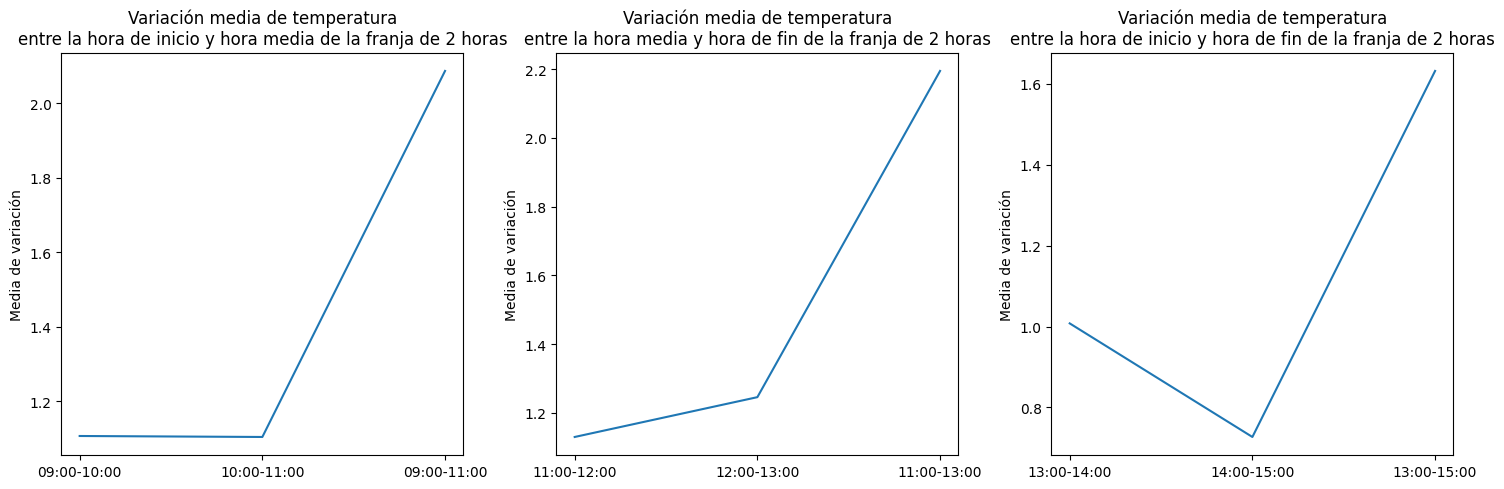

In [ ]:
pintar_variacion_media(mañana_f1, mañana_f2, mañana_f3, 'temperatura', 9 , 15)

Tal y como puede apreciarse con los resultados obtenidos, en general, la variación media de temperatura no es elevada en las franjas de hora inicio-hora media y hora media-hora fin. Sin embargo, en la franja de hora media-hora fin, si se aprecia mayor variación media de temperatura de 2.2 grados como máximo.

##### Humedad horario mañana

###### Franja 09:00 a 11:00

Comenzamos analizando las variaciones de humedad que se producen en la franja horaria de 9 a 11.

In [ ]:
mañana_f1_h = variacion(h_mañana1, '09:00', '10:00', '11:00', 'Humidity')
mañana_f1_h.head(1)

,Date,Diferencia 09:00-10:00,Diferencia 09:00-11:00,Diferencia 10:00-11:00
0,01/11/2023,1.0,5.0,4.0


In [ ]:
mañana_f1_h.shape

(152, 4)

In [ ]:
mañana_f1_h['Diferencia 09:00-10:00'].describe()

count    152.000000
mean       4.828947
std        3.640785
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       19.000000
Name: Diferencia 09:00-10:00, dtype: float64

In [ ]:
mañana_f1_h['Diferencia 09:00-11:00'].describe()

count    152.000000
mean       8.861842
std        6.096410
min        0.000000
25%        4.000000
50%        8.000000
75%       13.000000
max       29.000000
Name: Diferencia 09:00-11:00, dtype: float64

In [ ]:
mañana_f1_h['Diferencia 10:00-11:00'].describe()

count    152.000000
mean       4.572368
std        3.616742
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       18.000000
Name: Diferencia 10:00-11:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de humedad de las 09:00 a las 10:00 oscilan entre 0 y 19. Las variaciones de humedad de las 09:00 a las 11:00 oscilan entre 0 y 29 y las variaciones de humedad de las 10:00 a las 11:00 oscilan entre 0 y 18.

###### Franja 11:00 a 13:00

Se continúa analizando las variaciones de temperatura que se producen en la franja horaria de 11 a 13.

In [ ]:
mañana_f2_h = variacion(h_mañana2, '11:00', '12:00', '13:00', 'Humidity')
mañana_f2_h.head(1)

,Date,Diferencia 11:00-12:00,Diferencia 11:00-13:00,Diferencia 12:00-13:00
0,01/11/2023,1.0,1.0,0.0


In [ ]:
mañana_f2.shape

(152, 4)

In [ ]:
mañana_f2_h['Diferencia 11:00-12:00'].describe()

count    152.000000
mean       5.032895
std        6.603649
min        0.000000
25%        2.000000
50%        4.000000
75%        6.250000
max       75.000000
Name: Diferencia 11:00-12:00, dtype: float64

In [ ]:
mañana_f2_h['Diferencia 11:00-13:00'].describe()

count    152.000000
mean       8.743421
std        7.450052
min        0.000000
25%        5.000000
50%        8.000000
75%       11.250000
max       73.000000
Name: Diferencia 11:00-13:00, dtype: float64

In [ ]:
mañana_f2_h['Diferencia 12:00-13:00'].describe()

count    152.000000
mean       5.184211
std        8.289003
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       75.000000
Name: Diferencia 12:00-13:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de humedad de las 11:00 a las 12:00 oscilan entre 0 y 75. Las variaciones de humedad de las 11:00 a las 13:00 oscilan entre 0 y 73 y las variaciones de humedad de las 12:00 a las 13:00 oscilan entre 0 y 75.

###### Franja 13:00 a 15:00

Se continúa analizando las variaciones de temperatura que se producen en la franja horaria de 11 a 13.

In [ ]:
mañana_f3_h = variacion(h_mañana3, '13:00', '14:00', '15:00', 'Humidity')
mañana_f3_h.head(1)

,Date,Diferencia 13:00-14:00,Diferencia 13:00-15:00,Diferencia 14:00-15:00
0,01/11/2023,1.0,2.0,3.0


In [ ]:
mañana_f3_h.shape

(152, 4)

In [ ]:
mañana_f3_h['Diferencia 13:00-14:00'].describe()

count    152.000000
mean       4.381579
std        5.124844
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       54.000000
Name: Diferencia 13:00-14:00, dtype: float64

In [ ]:
mañana_f3_h['Diferencia 13:00-15:00'].describe()

count    152.000000
mean       7.144737
std        6.266074
min        0.000000
25%        4.000000
50%        6.000000
75%       10.000000
max       57.000000
Name: Diferencia 13:00-15:00, dtype: float64

In [ ]:
mañana_f3_h['Diferencia 14:00-15:00'].describe()

count    152.000000
mean       3.421053
std        3.370158
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       20.000000
Name: Diferencia 14:00-15:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de humedad de las 13:00 a las 14:00 oscilan entre 0 y 54. Las variaciones de humedad de las 13:00 a las 15:00 oscilan entre 0 y 57 y las variaciones de humedad de las 09:00 a las 11:00 oscilan entre 0 y 27.

###### Comparación visual

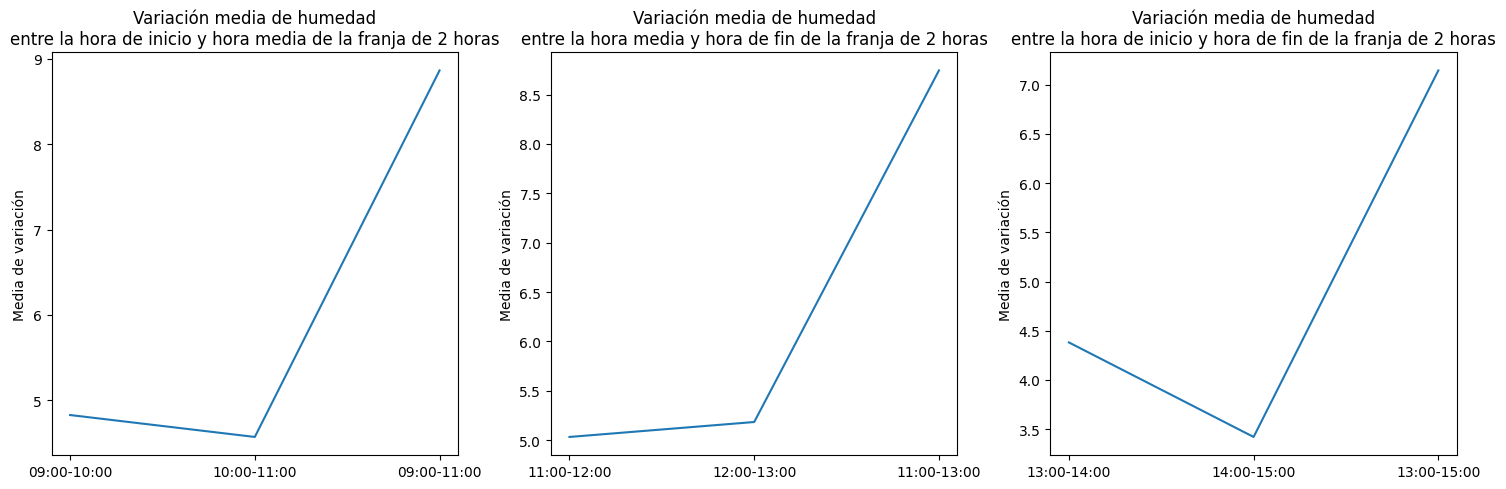

In [ ]:
pintar_variacion_media(mañana_f1_h, mañana_f2_h, mañana_f3_h, 'humedad', 9, 15)

Tal y como puede apreciarse con los resultados obtenidos, en general, la variación media de temperatura no es elevada en las franjas de hora inicio-hora media y hora media-hora fin. Sin embargo, en la franja de hora inicio-hora media, si se aprecia mayor variación media de humedad.

##### Temperatura horario tarde

###### Franja 15:00 a 17:00

Comenzamos analizando las variaciones de temperatura que se producen en la franja horaria de 15 a 17.

In [ ]:
tarde_f1 = variacion(h_tarde1, '15:00', '16:00', '17:00', 'Temperature')
tarde_f1.head(1)

,Date,Diferencia 15:00-16:00,Diferencia 15:00-17:00,Diferencia 16:00-17:00
0,01/11/2023,0.0,0.3,0.3


In [ ]:
tarde_f1.shape

(152, 4)

In [ ]:
tarde_f1['Diferencia 15:00-16:00'].describe()

count    152.000000
mean       0.588158
std        0.449714
min        0.000000
25%        0.200000
50%        0.500000
75%        0.900000
max        2.100000
Name: Diferencia 15:00-16:00, dtype: float64

In [ ]:
tarde_f1['Diferencia 15:00-17:00'].describe()

count    152.000000
mean       0.791447
std        0.688500
min        0.000000
25%        0.300000
50%        0.600000
75%        1.125000
max        5.300000
Name: Diferencia 15:00-17:00, dtype: float64

In [ ]:
tarde_f1['Diferencia 16:00-17:00'].describe()

count    152.000000
mean       0.486184
std        0.467351
min        0.000000
25%        0.200000
50%        0.400000
75%        0.700000
max        4.000000
Name: Diferencia 16:00-17:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de temperatura de las 15:00 a las 16:00 oscilan entre 0 y 2.1 grados. Las variaciones de temperatura de las 15:00 a las 17:00 oscilan entre 0 y 5.3 grados y las variaciones de temperatura de las 16:00 a las 17:00 oscilan entre 0 y 4 grados.

###### Franja 17:00 a 19:00

Se continúa analizando las variaciones de temperatura que se producen en la franja horaria de 17 a 19.

In [ ]:
tarde_f2 = variacion(h_tarde2, '17:00', '18:00', '19:00', 'Temperature')
tarde_f2.head(1)

,Date,Diferencia 17:00-18:00,Diferencia 17:00-19:00,Diferencia 18:00-19:00
0,01/11/2023,0.3,0.3,0.6


In [ ]:
tarde_f2.shape

(152, 4)

In [ ]:
tarde_f2['Diferencia 17:00-18:00'].describe()

count    152.000000
mean       0.663816
std        0.549117
min        0.000000
25%        0.300000
50%        0.500000
75%        0.900000
max        2.800000
Name: Diferencia 17:00-18:00, dtype: float64

In [ ]:
tarde_f2['Diferencia 17:00-19:00'].describe()

count    152.000000
mean       1.364474
std        0.966417
min        0.000000
25%        0.600000
50%        1.200000
75%        1.825000
max        4.900000
Name: Diferencia 17:00-19:00, dtype: float64

In [ ]:
tarde_f2['Diferencia 18:00-19:00'].describe()

count    152.000000
mean       0.799342
std        0.489289
min        0.000000
25%        0.400000
50%        0.700000
75%        1.100000
max        2.500000
Name: Diferencia 18:00-19:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de temperatura de las 17:00 a las 18:00 oscilan entre 0 y 2.8 grados. Las variaciones de temperatura de las 17:00 a las 18:00 oscilan entre 0 y 4.9 grados y las variaciones de temperatura de las 18:00 a las 19:00 oscilan entre 0 y 2.5 grados.

###### Franja 19:00 a 21:00

Se continúa analizando las variaciones de temperatura que se producen en la franja horaria de 19 a 21.

In [ ]:
tarde_f3 = variacion(h_tarde3, '19:00', '20:00', '21:00', 'Temperature')
tarde_f3.head(1)

,Date,Diferencia 19:00-20:00,Diferencia 19:00-21:00,Diferencia 20:00-21:00
0,01/11/2023,0.1,0.3,0.2


In [ ]:
tarde_f3.shape

(152, 4)

In [ ]:
tarde_f3['Diferencia 19:00-20:00'].describe()

count    152.000000
mean       0.666447
std        0.420020
min        0.000000
25%        0.400000
50%        0.600000
75%        0.900000
max        2.200000
Name: Diferencia 19:00-20:00, dtype: float64

In [ ]:
tarde_f3['Diferencia 19:00-21:00'].describe()

count    152.000000
mean       1.119079
std        0.655969
min        0.000000
25%        0.700000
50%        1.000000
75%        1.500000
max        4.000000
Name: Diferencia 19:00-21:00, dtype: float64

In [ ]:
tarde_f3['Diferencia 20:00-21:00'].describe()

count    152.000000
mean       0.486842
std        0.337440
min        0.000000
25%        0.200000
50%        0.450000
75%        0.700000
max        2.100000
Name: Diferencia 20:00-21:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de temperatura de las 19:00 a las 20:00 oscilan entre 0 y 2.2 grados. Las variaciones de temperatura de las 10:00 a las 21:00 oscilan entre 0 y 4 grados y las variaciones de temperatura de las 09:00 a las 11:00 oscilan entre 0 y 2.1 grados.

###### Comparación visual

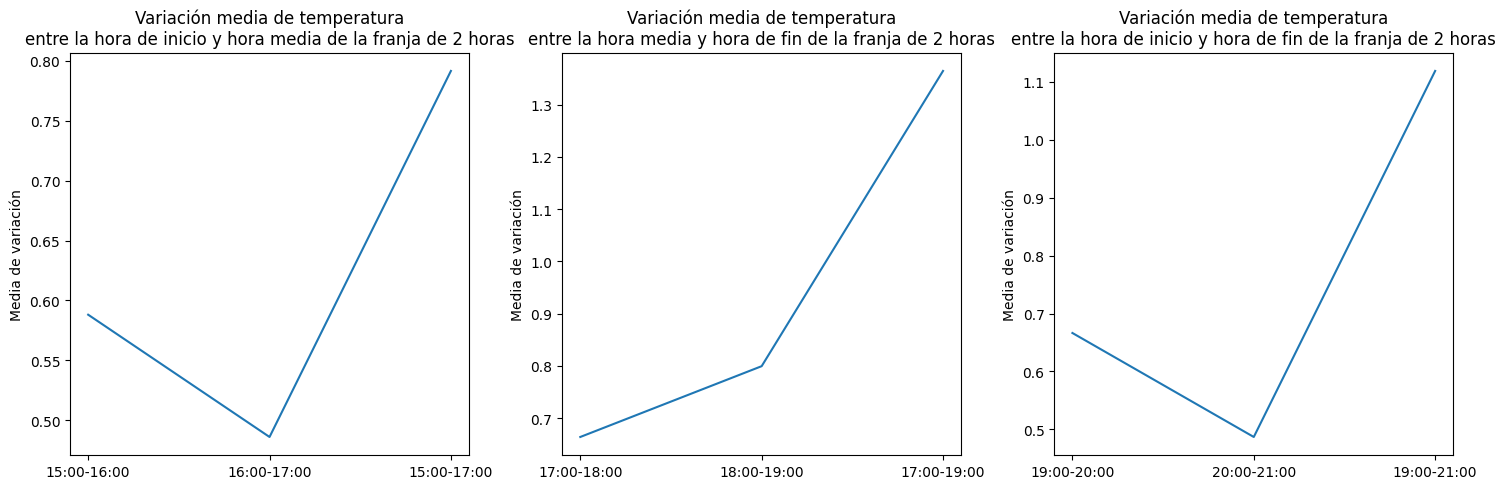

In [ ]:
pintar_variacion_media(tarde_f1, tarde_f2, tarde_f3, 'temperatura', 15 , 21)

Tal y como puede apreciarse con los resultados obtenidos, en general, la variación media de temperatura no es elevada en las franjas de hora inicio-hora media y hora media-hora fin. Sin embargo, en la franja de hora media-hora fin, si se aprecia mayor variación media de temperatura.

##### Humedad horario tarde

###### Franja 15:00 a 17:00

Comenzamos analizando las variaciones de humedad que se producen en la franja horaria de 15 a 17.

In [ ]:
tarde_f1_h = variacion(h_tarde1, '15:00', '16:00', '17:00', 'Humidity')
tarde_f1_h.head(1)

,Date,Diferencia 15:00-16:00,Diferencia 15:00-17:00,Diferencia 16:00-17:00
0,01/11/2023,2.0,2.0,0.0


In [ ]:
tarde_f1_h.shape

(152, 4)

In [ ]:
tarde_f1_h['Diferencia 15:00-16:00'].describe()

count    152.000000
mean       2.907895
std        2.784430
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       19.000000
Name: Diferencia 15:00-16:00, dtype: float64

In [ ]:
tarde_f1_h['Diferencia 15:00-17:00'].describe()

count    152.000000
mean       4.736842
std        4.427094
min        0.000000
25%        2.000000
50%        3.000000
75%        6.250000
max       25.000000
Name: Diferencia 15:00-17:00, dtype: float64

In [ ]:
tarde_f1_h['Diferencia 16:00-17:00'].describe()

count    152.000000
mean       2.960526
std        2.649207
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       15.000000
Name: Diferencia 16:00-17:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de humedad de las 15:00 a las 16:00 oscilan entre 0 y 19. Las variaciones de humedad de las 15:00 a las 17:00 oscilan entre 0 y 25 y las variaciones de humedad de las 16:00 a las 17:00 oscilan entre 0 y 15.

###### Franja 17:00 a 19:00

Se continúa analizando las variaciones de humedad que se producen en la franja horaria de 17 a 19.

In [ ]:
tarde_f2_h = variacion(h_tarde2, '17:00', '18:00', '19:00', 'Humidity')
tarde_f2_h.head(1)

,Date,Diferencia 17:00-18:00,Diferencia 17:00-19:00,Diferencia 18:00-19:00
0,01/11/2023,1.0,5.0,6.0


In [ ]:
tarde_f2_h.shape

(152, 4)

In [ ]:
tarde_f2_h['Diferencia 17:00-18:00'].describe()

count    152.000000
mean       3.414474
std        2.645611
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       17.000000
Name: Diferencia 17:00-18:00, dtype: float64

In [ ]:
tarde_f2_h['Diferencia 17:00-19:00'].describe()

count    152.000000
mean       6.414474
std        4.562218
min        0.000000
25%        3.000000
50%        5.500000
75%        9.000000
max       24.000000
Name: Diferencia 17:00-19:00, dtype: float64

In [ ]:
tarde_f2_h['Diferencia 18:00-19:00'].describe()

count    152.000000
mean       3.644737
std        2.645521
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       12.000000
Name: Diferencia 18:00-19:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de humedad de las 17:00 a las 18:00 oscilan entre 0 y 17. Las variaciones de humedad de las 17:00 a las 19:00 oscilan entre 1 y 24 y las variaciones de humedad de las 18:00 a las 19:00 oscilan entre 0 y 12.

###### Franja 19:00 a 21:00

Se continúa analizando las variaciones de humedad que se producen en la franja horaria de 11 a 13.

In [ ]:
tarde_f3_h = variacion(h_tarde3, '19:00', '20:00', '21:00', 'Humidity')
tarde_f3_h.head(1)

,Date,Diferencia 19:00-20:00,Diferencia 19:00-21:00,Diferencia 20:00-21:00
0,01/11/2023,3.0,2.0,1.0


In [ ]:
tarde_f3_h.shape

(152, 4)

In [ ]:
tarde_f3_h['Diferencia 19:00-20:00'].describe()

count    152.000000
mean       3.565789
std        3.146892
min        0.000000
25%        1.750000
50%        3.000000
75%        4.000000
max       19.000000
Name: Diferencia 19:00-20:00, dtype: float64

In [ ]:
tarde_f3_h['Diferencia 19:00-21:00'].describe()

count    152.000000
mean       5.934211
std        4.651669
min        0.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       32.000000
Name: Diferencia 19:00-21:00, dtype: float64

In [ ]:
tarde_f3_h['Diferencia 20:00-21:00'].describe()

count    152.000000
mean       2.736842
std        2.352220
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       17.000000
Name: Diferencia 20:00-21:00, dtype: float64

Tal y como muestran los resultados obtenidos, las variaciones de humedad de las 19:00 a las 20:00 oscilan entre 0 y 19. Las variaciones de humedad de las 19:00 a las 21:00 oscilan entre 0 y 32 y las variaciones de humedad de las 20:00 a las 21:00 oscilan entre 0 y 17.

###### Comparación visual

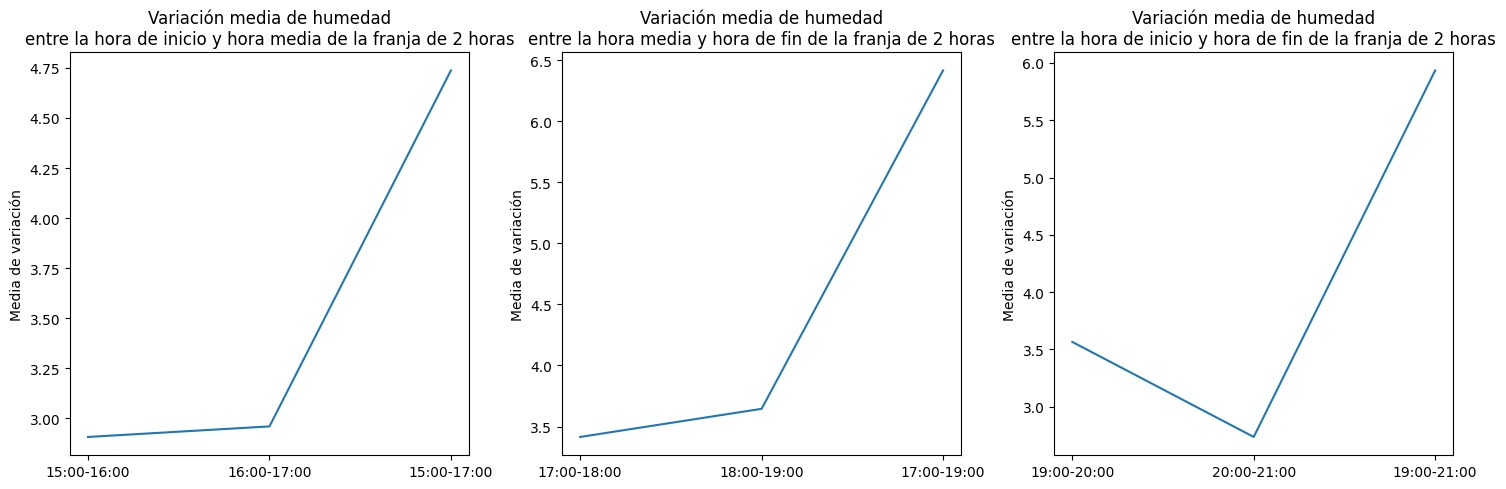

In [ ]:
pintar_variacion_media(tarde_f1_h, tarde_f2_h, tarde_f3_h, 'humedad', 15 , 21)

Tal y como puede apreciarse con los resultados obtenidos, en general, la variación media de temperatura no es elevada en las franjas de hora inicio-hora media y hora media-hora fin. Sin embargo, en la franja de hora media-hora fin, si se aprecia mayor variación media de humedad.

#### Unificación de los datos

Tal y como se ha comprobado anteriormente, existe una variación de tamperatura entre las diferentes horas de la franja horaria de 2 horas considerada. Por ese motivo, para añadir los datos medioambientales al DataFrame final, para cada una de las muestras ya existentes actualmente en el mismo, es decir, los cuestionarios de bienestar, se añadirán 4 nuevas columnas para contener las mediciones de temperatura y humedad para las horas de inicio y fin de la franja de 2 horas que toman el nombre de HIC y HFC y otras dos columnas para contener las mediciones de temperatura y humedad para la hora media de la franja de dos horas. En total se añadirán 6 nuevas columnas.

En primer lugar, debemos asegurarnos de que las columnas por las que vamos a realizar la unión presentan el mismo formato. Tal y como se puede observar, la columna que contiene la hora de la muestra en los datos meteorológicos no contiene los segundos a diferencia de las muestras del DataFrame final. Además, la hora de las 9 de la mañana, presenta un 0 adicional a la izquierda en los datos meteorológicos. Además, es necesario modificar el formato de las fechas del DataFrame final para que adopten la forma dd/mm/yyyy.

In [ ]:
df_dm.head(3)

,Date,Time,Temperature,Humidity
0,01/11/2023,01:00,7.4,85.0
1,01/11/2023,02:00,6.4,89.0
2,01/11/2023,03:00,6.0,91.0


In [ ]:
final_data.head(3)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo
0,2023-11-08,9:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M
1,2023-11-08,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M
2,2023-11-08,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M


Función `agregar_minutos`: función encargada de añadir los minutos a las horas de los datos meterorológicos para que presenten el formato hh:MM:ss.

In [ ]:
def agregar_minutos(valor):
    return valor + ':00'

df_dm['Time'] = df_dm['Time'].apply(agregar_minutos)

Función `ajustar_formato`: función encargada de añadir un 0 a la izquierda de los datos del DataFrame final para que las 9:00:00 presente el formato 09:00:00, el mismo formato que los datos meteorológicos.

In [ ]:
def ajustar_formato(hora):
    partes = hora.split(':')
    if len(partes[0]) == 1:
        partes[0] = '0' + partes[0]
    return ':'.join(partes)

final_data['HIC'] = final_data['HIC'].apply(ajustar_formato)

In [ ]:
final_data['Date'] = final_data['Date'].dt.strftime('%d/%m/%Y')

In [ ]:
df_dm.head(1)

,Date,Time,Temperature,Humidity
0,01/11/2023,01:00:00,7.4,85.0


In [ ]:
final_data.head(1)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M


Función `obtener_valor`:función encargada de, para cada fila del DataFrame final, encontrar la fila en los datos meteorológicos con la misma fecha y hora de inicio, medio o fin de la franja (parámetro *hora*) y añadir el valor correspondiente de la variable (parámetro *var*) seleccionada. El parámetro *hora_media* se emplea para generar la hora media de la franja de dos horas ya que a diferencia de las horas de inicio y fin que se recogen en una columa propia del DataFrame (HIC,HFC), esta hora media no se encuentra recogida como tal en los datos.

In [ ]:
def obtener_valor(row, df, hora, var, hora_media= False):
  if hora_media:
    aux = int(row[hora].split(':')[0]) + 1
    hora = str(aux) + ':00:00'
    matching_row = df[(df['Date'] == row['Date']) & (df['Time'] == hora)]

  else:
    matching_row = df[(df['Date'] == row['Date']) & (df['Time'] == row[hora])]

  if not matching_row.empty:
       return matching_row[var].values[0]
  else:
      return None

final_data['TempEXTHIC'] = final_data.apply(obtener_valor, args=(df_dm, 'HIC', 'Temperature',), axis=1)
final_data['TempEXTMED'] = final_data.apply(obtener_valor, args=(df_dm, 'HIC', 'Temperature', True,), axis=1)
final_data['TempEXTHFC'] = final_data.apply(obtener_valor, args=(df_dm, 'HFC', 'Temperature',), axis=1)
final_data['HumEXTHIC'] = final_data.apply(obtener_valor, args=(df_dm, 'HIC', 'Humidity',), axis=1)
final_data['HumEXTMED'] = final_data.apply(obtener_valor, args=(df_dm, 'HIC', 'Humidity', True,), axis=1)
final_data['HumEXTHFC'] = final_data.apply(obtener_valor, args=(df_dm, 'HFC', 'Humidity',), axis=1)

In [ ]:
final_data.head(3)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0


Verificamos que no existan valores nulos en el conjunto de datos. Tal y como puede observarse, no existen falores faltantes en el conjunto de datos.

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                995 non-null    object 
 1   HIC                 995 non-null    object 
 2   HFC                 995 non-null    object 
 3   Mota                995 non-null    object 
 4   Puesto              995 non-null    object 
 5   Luces_apagadas      995 non-null    object 
 6   Cortinas_abiertas   995 non-null    float64
 7   Luminosidad         995 non-null    int64  
 8   Ruido               995 non-null    int64  
 9   AACC_enc            995 non-null    object 
 10  Calefacción_enc     995 non-null    object 
 11  Ventanas_abiertas   995 non-null    object 
 12  Temperatura         995 non-null    int64  
 13  Ambiente_cargado    995 non-null    int64  
 14  Ocupación_aula      995 non-null    int64  
 15  Comodidad_aula      995 non-null    int64  
 16  E_anímic

In [ ]:
filas_con_nulos = final_data[final_data.isna().any(axis=1)]
filas_con_nulos

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC


In [ ]:
final_data.shape

(995, 28)

### final_data(C4,C1) + C2

El conjunto de datos C2, que contiene los datos de las mediciones de las distintas magnitudes de temperatura, humedad y luminosidad de las motas del aula 3301, presenta una periodicidad de 5 minutos. Sin embargo, tal y como ya se ha comentado, se ha decidido fijar la periodicidad a 2 horas puesto que cada uno de los cuestionarios de bienestar recoge datos para una franja de 2 horas. Puesto que, como se analizó previamente, estas magnitudes físicas no se ajustan a una distribución normal, para reducir la periodicidad de estos datos no nos quedaremos simplemente con la media sino que almacenaremos, para cada variable, su valor máximo y mínimo, su valor medio y cada uno de los tres cuartiles. Así, el número total de columnas a añadir al DataFrame final es de 18 (3 magnitudes físicas x 6 valores que se almacenan de cada una).

En primer lugar, es necesario asegurar que los campos por los que vamos a unir ambos DataFrames, *Date* y *Time*, presentan el mismo formato. Vemos que la columna *Time* de los datos recogidos por las motas del aula 3301 no contiene los segundos en la hora a diferencia de los datos del DataFrame final.

In [ ]:
final_data.head(3)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0


In [ ]:
df_dm3301.head(3)

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,01/11/2023,00:00,25.198536,46.745758,0.0,M1
1,01/11/2023,00:05,25.182425,46.717809,0.0,M1
2,01/11/2023,00:10,25.162131,46.698736,0.0,M1


Vemos que los datos de las motas del aula 3301 no contienen los segundos. es necesario añadirlos para que las muestras de ambos conjuntos tengan el mismo formato.

In [ ]:
df_dm3301['Time'] = df_dm3301['Time'].apply(agregar_minutos)

In [ ]:
df_dm3301.head(3)

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,01/11/2023,00:00:00,25.198536,46.745758,0.0,M1
1,01/11/2023,00:05:00,25.182425,46.717809,0.0,M1
2,01/11/2023,00:10:00,25.162131,46.698736,0.0,M1


Una vez corregido este formato no es necesario realizar más modificaciones sobre los datos. Podemos proceder a unificar ambos conjuntos de datos.

#### Funciones de unificación de datos

Función `get_tiempos`: función auxiliar encargada de generar una lista de fechas para facilitar la obtención de las muestras coincidentes en la función `get_metrics`. Recibe como parámetro la hora de inicio y genera horas cada minuto a lo largo de un periodo de dos horas.

In [ ]:
def get_tiempos(h_inicio):
  tiempo_actual = h_inicio
  lista_tiempo = []
  for _ in range(121):
      lista_tiempo.append(tiempo_actual)
      horas, minutos, segundos = map(int, tiempo_actual.split(':'))
      minutos += 1
      if minutos >= 60:
          minutos -= 60
          horas += 1
      tiempo_actual = '{:02d}:{:02d}:{:02d}'.format(horas, minutos, segundos)
  return lista_tiempo

Función `get_metrics`: función encargada de obtener para cada fila de un DataFrame el conjunto de filas relacionadas de un segundo DataFrame de medidas y calcular el mínimo, máximo, media y cuartiles de ese conjunto de filas relacionadas para poder unificar ambos conjuntos de datos. Recibe como parámetros la fila para la cual se quieren calcular las métricas, el DataFrame dónde se encuentran las filas relacionadas con la misma, la variable sobre la que se quieren calcular las métricas y el aula a la que pertenecen las filas que queremos tratar.

In [ ]:
def get_metrics(row, df, var, aula):
  metricas = ['ValorDesconocido' for i in range(6)]

  if (row['Aula'] == aula):
    tiempos = get_tiempos(row['HIC'])
    matching_rows = df[(df['Date'] == row['Date']) & (df['Time'].isin(tiempos)) & (df['Mota'] == row['Mota'])]
    matching_rows = matching_rows.dropna()
    cuartiles = matching_rows[var].quantile([0.25, 0.5, 0.75], interpolation='linear')

    min = matching_rows[var].min()
    max = matching_rows[var].max()
    media = matching_rows[var].mean()
    q1 = cuartiles[0.25]
    q2 = cuartiles[0.5]
    q3 = cuartiles[0.75]
    metricas = [min, max, media, q1, q2, q3]

  return metricas

#### Unificación de datos temporal

##### Temperatura

In [ ]:
aux = final_data.apply(get_metrics, args=(df_dm3301,'Temperature', '3301',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
final_data['TempINTMIN'] = min_val
final_data['TempINTMAX'] = max_val
final_data['TempINTMED'] = media_val
final_data['TempINTQ1'] = q1_val
final_data['TempINTQ2'] = q2_val
final_data['TempINTQ3'] = q3_val


In [ ]:
final_data

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839
3,10/11/2023,09:00:00,11:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,6.0,7.0,8.7,69.0,67.0,62.0,26.964212,28.518001,27.839594,27.492156,27.918444,28.219999
4,10/11/2023,11:00:00,13:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,8.7,9.7,9.9,62.0,60.0,62.0,28.518001,29.628583,29.142327,28.89629,29.166293,29.450104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
993,06/02/2024,15:00:00,17:00:00,M2,14,No,3.0,5,5,No,No,Sí,5,5,4,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Enérgico/a,3304,T,10.3,11.4,11.3,56.0,53.0,58.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido


##### Luminosidad

In [ ]:
aux = final_data.apply(get_metrics, args=(df_dm3301,'Luminosity','3301',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
final_data['LumINTMIN'] = min_val
final_data['LumINTMAX'] = max_val
final_data['LumINTMED'] = media_val
final_data['LumINTQ1'] = q1_val
final_data['LumINTQ2'] = q2_val
final_data['LumINTQ3'] = q3_val


In [ ]:
final_data

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719
3,10/11/2023,09:00:00,11:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,6.0,7.0,8.7,69.0,67.0,62.0,26.964212,28.518001,27.839594,27.492156,27.918444,28.219999,793.624698,864.254892,837.202545,824.258006,838.106261,854.049835
4,10/11/2023,11:00:00,13:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,8.7,9.7,9.9,62.0,60.0,62.0,28.518001,29.628583,29.142327,28.89629,29.166293,29.450104,760.550388,864.401053,802.252856,774.805867,799.704834,825.340787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
993,06/02/2024,15:00:00,17:00:00,M2,14,No,3.0,5,5,No,No,Sí,5,5,4,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Enérgico/a,3304,T,10.3,11.4,11.3,56.0,53.0,58.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido


##### Humedad

In [ ]:
aux = final_data.apply(get_metrics, args=(df_dm3301,'Humidity', '3301',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
final_data['HumINTMIN'] = min_val
final_data['HumINTMAX'] = max_val
final_data['HumINTMED'] = media_val
final_data['HumINTQ1'] = q1_val
final_data['HumINTQ2'] = q2_val
final_data['HumINTQ3'] = q3_val


In [ ]:
final_data

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468,35.834612,36.646895,36.268024,36.185403,36.234019,36.420396
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469,35.545197,36.440069,35.971543,35.735653,35.994975,36.20287
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719,34.984141,36.321068,35.725872,35.407964,35.756204,36.055288
3,10/11/2023,09:00:00,11:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,6.0,7.0,8.7,69.0,67.0,62.0,26.964212,28.518001,27.839594,27.492156,27.918444,28.219999,793.624698,864.254892,837.202545,824.258006,838.106261,854.049835,33.129251,33.733319,33.401071,33.195444,33.408394,33.561461
4,10/11/2023,11:00:00,13:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,8.7,9.7,9.9,62.0,60.0,62.0,28.518001,29.628583,29.142327,28.89629,29.166293,29.450104,760.550388,864.401053,802.252856,774.805867,799.704834,825.340787,33.344741,34.56371,34.077097,33.990447,34.118624,34.335508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,Valor

#### Imputación de valores

Una vez que hemos unificado ambos conjuntos de datos, es necesario comprobar la existencia de valores faltantes (nan o ValorDesconocido) puesto que, como ya se comentó en notebooks anteriores, existen ciertos días para los que no se disponen de mediciones por parte de las motas sensoras.

In [ ]:
aux = final_data[(final_data == 'ValorDesconocido').any(axis=1)]
aux.shape

(389, 46)

In [ ]:
aux.Aula.unique()

array(['3304'], dtype=object)

Tal y como puede observarse, existen 389 filas con valores desconocidos. Estos valores pertenecen al aula 3304 y se rellenarán en la subsección posterior.

Comprobemos ahora los valores nulos.

In [ ]:
aux = final_data[final_data.isnull().any(axis=1)]
aux.shape

(32, 46)

In [ ]:
aux.Aula.unique()

array(['3301'], dtype=object)

In [ ]:
aux.Mota.unique()

array(['M1', 'M2'], dtype=object)

Tal y como puede verse, existen 32 filas de cuestionarios del aula 3301 con valores nulos. Esto se debe a la inexistencia de datos de las motas sensoras para estos días. Veámos que días son.

In [ ]:
aux.Date.unique()

array(['30/01/2024', '31/01/2024', '29/02/2024', '05/03/2024',
       '06/03/2024', '08/03/2024', '12/02/2024', '04/12/2023',
       '05/12/2023'], dtype=object)

Hay valores faltantes para 9 días en las motas del aula 3301. Es momento de tratar estas muestras de manera independiente.

##### Análisis de estacionariedad

Las tres variables para las que necesitamos imputar valores faltantes, son series temporales al uso. Si estas tres variables son estacionarias, podríamos rellenar los valores faltantes de cada muestra con los valores del día anterior, posterior o más cercano en su defecto de esa muestra. Comprobemos entonces si las variables son estacionarias aplicando el test de Dickey Fuller.

In [ ]:
def test_df_df(dataframe, var):
  result = adfuller(dataframe[var].loc[:])
  if result[1] < 0.05:
    print(f"La variable {var} es estacionaria")
  else: print(f"La variable {var} no es estacionaria")

for column in df_dm3301.columns:
  if column != 'Date' and column!= 'Time' and column!= 'Mota':
    test_df_df(df_dm3301, column)

La variable Temperature es estacionaria
La variable Humidity es estacionaria
La variable Luminosity es estacionaria


Se puede concluir que las tres variables son estacionarias. Se continua entonces con la estrategia planteada.

##### 04/12/2023

In [ ]:
f1 = aux[aux.Date == '04/12/2023']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
578,04/12/2023,17:00:00,19:00:00,M1,5001 01 18,No,3.0,4,4,No,Sí,Parcialmente,4,3,3,4,De acuerdo,Normal,De acuerdo,Normal,3301,T,7.1,6.3,5.3,77.0,80.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,04/12/2023,17:00:00,19:00:00,M1,Tercera fila segundo asiento desde la derecha,Sí,3.0,5,5,No,Sí,Parcialmente,3,4,2,3,De acuerdo,Normal,De acuerdo,Normal,3301,T,7.1,6.3,5.3,77.0,80.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
580,04/12/2023,17:00:00,19:00:00,M1,sala2pc17,No,3.0,5,4,No,Sí,Parcialmente,5,5,2,4,De acuerdo,Normal,De acuerdo,Normal,3301,T,7.1,6.3,5.3,77.0,80.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581,04/12/2023,19:00:00,21:00:00,M1,5007 03 04,No,3.0,5,5,No,Sí,Parcialmente,4,5,1,5,En desacuerdo,Aburrido;Dormido,En desacuerdo,Agotado/a;Con sueño,3301,T,5.3,4.6,4.6,85.0,88.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,04/12/2023,19:00:00,21:00:00,M2,"Tercer asiento desde la derecha, séptima fila",No,3.0,5,5,No,Sí,Parcialmente,4,5,2,5,Totalmente de acuerdo,Normal;Cansado,Totalmente de acuerdo,Normal;Con sueño,3301,T,5.3,4.6,4.6,85.0,88.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '04/12/2023')]


,Date,Time,Temperature,Humidity,Luminosity,Mota


Efectivamente, no hay datos para el 4 de diciembre para ninguna de las dos motas. Sin embargo, tal y como puede observarse, existen 5 muestras con valores nulos para esta fecha. 4 de ellas pertenecen a la M1 y 1 pertenece a la M2.

###### M1

Veamos si existen datos para el día anterior o posterior para poder rellenar estos valores faltantes.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '05/12/2023') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
9485,05/12/2023,21:03:00,25.574120,39.555562,0.0,M1
9486,05/12/2023,21:05:00,25.403444,39.631220,0.0,M1
9487,05/12/2023,21:10:00,25.142371,39.791845,0.0,M1
9488,05/12/2023,21:15:00,24.930840,39.977315,0.0,M1
9489,05/12/2023,21:20:00,24.750508,40.104570,0.0,M1
9490,05/12/2023,21:25:00,24.592684,40.223821,0.0,M1
9491,05/12/2023,21:30:00,24.451382,40.335490,0.0,M1
9492,05/12/2023,21:35:00,24.319929,40.433825,0.0,M1
9493,05/12/2023,21:40:00,24.198024,40.528212,0.0,M1
9494,05/12/2023,21:45:00,24.090129,40.580139,0.0,M1


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '03/12/2023') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
9197,03/12/2023,00:00:00,23.334963,30.788549,0.0,M1
9198,03/12/2023,00:05:00,23.318185,30.806936,0.0,M1
9199,03/12/2023,00:10:00,23.313868,30.821482,0.0,M1
9200,03/12/2023,00:15:00,23.311776,30.813802,0.0,M1
9201,03/12/2023,00:20:00,23.308973,30.834783,0.0,M1
...,...,...,...,...,...,...
9480,03/12/2023,23:35:00,20.891745,33.664932,0.0,M1
9481,03/12/2023,23:40:00,20.871764,33.708087,0.0,M1
9482,03/12/2023,23:45:00,20.871812,33.694458,0.0,M1
9483,03/12/2023,23:50:00,20.881776,33.682556,0.0,M1


Para el 5 de diciembre, si que existen datos pero no son de interés porque están incompletos y solo contienen mediciones para horas que no son de interés. Así, rellenaremos los datos faltantes del 04/12/2024 con los datos del día 03/12/2024.

In [ ]:
f1_m1['Date'] = '04/12/2023'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '04/12/2023') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,04/12/2023,00:00:00,23.334963,30.788549,0.0,M1
1,04/12/2023,00:05:00,23.318185,30.806936,0.0,M1
2,04/12/2023,00:10:00,23.313868,30.821482,0.0,M1
3,04/12/2023,00:15:00,23.311776,30.813802,0.0,M1
4,04/12/2023,00:20:00,23.308973,30.834783,0.0,M1
...,...,...,...,...,...,...
283,04/12/2023,23:35:00,20.891745,33.664932,0.0,M1
284,04/12/2023,23:40:00,20.871764,33.708087,0.0,M1
285,04/12/2023,23:45:00,20.871812,33.694458,0.0,M1
286,04/12/2023,23:50:00,20.881776,33.682556,0.0,M1


###### M2

Hagamos lo mismo para la M2.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '05/12/2023') & (df_dm3301.Mota == 'M2')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
42314,05/12/2023,21:03:00,27.047251,35.559387,0.0,M2
42315,05/12/2023,21:05:00,26.956684,35.486247,0.0,M2
42316,05/12/2023,21:10:00,26.786852,35.523631,0.0,M2
42317,05/12/2023,21:15:00,26.632281,35.606410,0.0,M2
42318,05/12/2023,21:20:00,26.497919,35.691161,0.0,M2
42319,05/12/2023,21:25:00,26.369480,35.759506,0.0,M2
42320,05/12/2023,21:30:00,26.279401,35.759989,0.0,M2
42321,05/12/2023,21:35:00,26.200200,35.740812,0.0,M2
42322,05/12/2023,21:40:00,26.122204,35.791957,0.0,M2
42323,05/12/2023,21:45:00,26.029901,35.856501,0.0,M2


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '03/12/2023') & (df_dm3301.Mota == 'M2')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
42026,03/12/2023,00:00:00,25.970220,26.149673,0.0,M2
42027,03/12/2023,00:05:00,25.961185,26.157074,0.0,M2
42028,03/12/2023,00:10:00,25.952596,26.166484,0.0,M2
42029,03/12/2023,00:15:00,25.942805,26.198578,0.0,M2
42030,03/12/2023,00:20:00,25.931723,26.217880,0.0,M2
...,...,...,...,...,...,...
42309,03/12/2023,23:35:00,22.140521,30.587387,0.0,M2
42310,03/12/2023,23:40:00,22.131531,30.601883,0.0,M2
42311,03/12/2023,23:45:00,22.127214,30.600382,0.0,M2
42312,03/12/2023,23:50:00,22.120449,30.612564,0.0,M2


A la vista de los resultados, todos los datos del 4 de diciembre se rellenarán con los datos del 3 de diciembre para ambas motas.

In [ ]:
f1_m1['Date'] = '04/12/2023'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '04/12/2023') & (df_dm3301.Mota == 'M2')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,04/12/2023,00:00:00,25.970220,26.149673,0.0,M2
1,04/12/2023,00:05:00,25.961185,26.157074,0.0,M2
2,04/12/2023,00:10:00,25.952596,26.166484,0.0,M2
3,04/12/2023,00:15:00,25.942805,26.198578,0.0,M2
4,04/12/2023,00:20:00,25.931723,26.217880,0.0,M2
...,...,...,...,...,...,...
283,04/12/2023,23:35:00,22.140521,30.587387,0.0,M2
284,04/12/2023,23:40:00,22.131531,30.601883,0.0,M2
285,04/12/2023,23:45:00,22.127214,30.600382,0.0,M2
286,04/12/2023,23:50:00,22.120449,30.612564,0.0,M2


##### 05/12/2023

In [ ]:
f1 = aux[aux.Date == '05/12/2023']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
583,05/12/2023,19:00:00,21:00:00,M1,"3301-01 (primera fila, ventana izquierda)",No,3.0,5,5,No,Sí,No,5,5,2,5,De acuerdo,Motivado;Normal;Agobiado;Estresado,De acuerdo,Normal,3301,T,4.4,4.1,3.8,62.0,63.0,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
auxs = df_dm3301[(df_dm3301.Date == '05/12/2023') & (df_dm3301.Mota == 'M1')]
auxs

,Date,Time,Temperature,Humidity,Luminosity,Mota
9485,05/12/2023,21:03:00,25.574120,39.555562,0.0,M1
9486,05/12/2023,21:05:00,25.403444,39.631220,0.0,M1
9487,05/12/2023,21:10:00,25.142371,39.791845,0.0,M1
9488,05/12/2023,21:15:00,24.930840,39.977315,0.0,M1
9489,05/12/2023,21:20:00,24.750508,40.104570,0.0,M1
9490,05/12/2023,21:25:00,24.592684,40.223821,0.0,M1
9491,05/12/2023,21:30:00,24.451382,40.335490,0.0,M1
9492,05/12/2023,21:35:00,24.319929,40.433825,0.0,M1
9493,05/12/2023,21:40:00,24.198024,40.528212,0.0,M1
9494,05/12/2023,21:45:00,24.090129,40.580139,0.0,M1


In [ ]:
auxs.shape

(36, 6)

Sí hay datos para el día 5 de diciembre pero no para las franjas horarias de interés. Solo hay datos desde las 9 de la noche en adelante.

Como hemos visto anteriormente, no existen datos para el 4 de diciembre. Veamos si existen datos para el 6 de diciembre.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '06/12/2023') & (df_dm3301.Mota == 'M1')].iloc[:252]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
9521,06/12/2023,00:00:00,22.690434,40.335186,0.0,M1
9522,06/12/2023,00:05:00,22.664083,40.282262,0.0,M1
9523,06/12/2023,00:10:00,22.634947,40.212082,0.0,M1
9524,06/12/2023,00:15:00,22.605754,40.132374,0.0,M1
9525,06/12/2023,00:20:00,22.575386,40.059106,0.0,M1
...,...,...,...,...,...,...
9768,06/12/2023,20:35:00,20.196743,37.340571,0.0,M1
9769,06/12/2023,20:40:00,20.183214,37.345403,0.0,M1
9770,06/12/2023,20:45:00,20.178832,37.363964,0.0,M1
9771,06/12/2023,20:50:00,20.176004,37.364095,0.0,M1


A la vista de los resultados, los datos faltantes del 5 de diciembre se rellenarán con los datos del 6 de diciembre.

In [ ]:
f1_m1['Date'] = '05/12/2023'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '05/12/2023') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
9485,05/12/2023,21:03:00,25.574120,39.555562,0.0,M1
9486,05/12/2023,21:05:00,25.403444,39.631220,0.0,M1
9487,05/12/2023,21:10:00,25.142371,39.791845,0.0,M1
9488,05/12/2023,21:15:00,24.930840,39.977315,0.0,M1
9489,05/12/2023,21:20:00,24.750508,40.104570,0.0,M1
...,...,...,...,...,...,...
247,05/12/2023,20:35:00,20.196743,37.340571,0.0,M1
248,05/12/2023,20:40:00,20.183214,37.345403,0.0,M1
249,05/12/2023,20:45:00,20.178832,37.363964,0.0,M1
250,05/12/2023,20:50:00,20.176004,37.364095,0.0,M1


##### 30/01/2024

In [ ]:
f1 = aux[aux.Date == '30/01/2024']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
353,30/01/2024,09:00:00,11:00:00,M1,5000 01 8,No,3.0,5,2,No,Sí,No,3,2,4,4,Ni de acuerdo ni en desacuerdo,Cansado,De acuerdo,Normal,3301,M,2.9,4.3,6.7,92.0,85.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,30/01/2024,09:00:00,11:00:00,M1,5001 01 9,No,5.0,5,5,No,Sí,No,2,2,4,3,Ni de acuerdo ni en desacuerdo,Cansado;Aburrido;Dormido,En desacuerdo,Normal,3301,M,2.9,4.3,6.7,92.0,85.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,30/01/2024,09:00:00,11:00:00,M1,5001017,No,5.0,5,5,No,Sí,Parcialmente,5,5,4,5,Totalmente de acuerdo,Normal,De acuerdo,Normal,3301,M,2.9,4.3,6.7,92.0,85.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516,30/01/2024,09:00:00,11:00:00,M1,"3301-03 (primera fila, pasillo izquierdo)",No,3.0,5,4,No,Sí,No,4,5,4,5,De acuerdo,Motivado;Normal;Cansado;Dormido,De acuerdo,Normal;Con sueño,3301,M,2.9,4.3,6.7,92.0,85.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '30/01/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota


Efectivamente, no hay datos de las motas para el 30 de enero. Además, tal y como puede observarse, hay 4 cuestionarios para esta fecha, todos pertenecientes a la mota 1. Veamos si hay datos para el 29 de enero puesto que para el 31 de diciembre (tratado en la subsección posterior), no hay datos.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '29/01/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '28/01/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '01/02/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
18480,01/02/2024,00:00:00,25.984016,34.129410,0.0,M1
18481,01/02/2024,00:05:00,25.953353,34.116687,0.0,M1
18482,01/02/2024,00:10:00,25.923890,34.098892,0.0,M1
18483,01/02/2024,00:15:00,25.897900,34.075139,0.0,M1
18484,01/02/2024,00:20:00,25.875824,34.039780,0.0,M1
...,...,...,...,...,...,...
18763,01/02/2024,23:35:00,26.839191,29.092407,0.0,M1
18764,01/02/2024,23:40:00,26.807628,29.057071,0.0,M1
18765,01/02/2024,23:45:00,26.772612,29.014969,0.0,M1
18766,01/02/2024,23:50:00,26.727567,29.008179,0.0,M1


Tal y como puede observarse, no hay datos para ninguno de los dos días previos. El día más cercano para el que se dispone de información es para el 1 de febrero. Así pues, los datos del 30  de enero se rellenarán con los datos del 1 de febrero.

In [ ]:
f1_m1['Date'] = '30/01/2024'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '30/01/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,30/01/2024,00:00:00,25.984016,34.129410,0.0,M1
1,30/01/2024,00:05:00,25.953353,34.116687,0.0,M1
2,30/01/2024,00:10:00,25.923890,34.098892,0.0,M1
3,30/01/2024,00:15:00,25.897900,34.075139,0.0,M1
4,30/01/2024,00:20:00,25.875824,34.039780,0.0,M1
...,...,...,...,...,...,...
283,30/01/2024,23:35:00,26.839191,29.092407,0.0,M1
284,30/01/2024,23:40:00,26.807628,29.057071,0.0,M1
285,30/01/2024,23:45:00,26.772612,29.014969,0.0,M1
286,30/01/2024,23:50:00,26.727567,29.008179,0.0,M1


##### 31/01/2024

In [ ]:
f1 = aux[aux.Date == '31/01/2024']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
356,31/01/2024,09:00:00,11:00:00,M1,5001 01 8,No,4.0,5,5,No,Sí,Parcialmente,5,5,3,5,Ni de acuerdo ni en desacuerdo,Cansado,De acuerdo,Normal;Con sueño,3301,M,0.5,0.7,1.7,92.0,93.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,31/01/2024,09:00:00,11:00:00,M1,5001018,No,5.0,5,5,No,Sí,Parcialmente,5,5,3,5,De acuerdo,Normal,De acuerdo,Normal,3301,M,0.5,0.7,1.7,92.0,93.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,31/01/2024,11:00:00,13:00:00,M1,5001 01 8,No,4.0,5,4,No,Sí,Parcialmente,4,3,3,4,De acuerdo,Motivado;Agobiado,Totalmente de acuerdo,Normal,3301,M,1.7,2.8,3.8,91.0,90.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '31/01/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
18351,31/01/2024,13:15:00,28.006392,30.551862,868.137378,M1
18352,31/01/2024,13:20:00,27.981653,30.638203,202.622651,M1
18353,31/01/2024,13:25:00,27.948504,30.610139,207.969194,M1
18354,31/01/2024,13:30:00,27.884148,30.499295,205.399505,M1
18355,31/01/2024,13:35:00,27.806074,30.438119,204.471771,M1
...,...,...,...,...,...,...
18475,31/01/2024,23:35:00,26.150553,34.263484,0.000000,M1
18476,31/01/2024,23:40:00,26.120068,34.245605,0.000000,M1
18477,31/01/2024,23:45:00,26.081170,34.211188,0.000000,M1
18478,31/01/2024,23:50:00,26.051593,34.185607,0.000000,M1


Sí hay datos para el 31 de enero, pero a partir de las 13:15. Solo necesitamos rellenar las horas anteriores.

Tal y como puede observarse, existen 3 muestras para estas fechas. No hay datos para en día anterior, como acabamos de comprobar, pero sí para el día posterior.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '01/02/2024') & (df_dm3301.Mota == 'M1')].iloc[:159]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
18480,01/02/2024,00:00:00,25.984016,34.129410,0.000000,M1
18481,01/02/2024,00:05:00,25.953353,34.116687,0.000000,M1
18482,01/02/2024,00:10:00,25.923890,34.098892,0.000000,M1
18483,01/02/2024,00:15:00,25.897900,34.075139,0.000000,M1
18484,01/02/2024,00:20:00,25.875824,34.039780,0.000000,M1
...,...,...,...,...,...,...
18634,01/02/2024,12:50:00,29.655665,31.777724,751.582176,M1
18635,01/02/2024,12:55:00,29.621682,31.813108,1004.579436,M1
18636,01/02/2024,13:00:00,29.478994,31.335672,882.335981,M1
18637,01/02/2024,13:05:00,29.311446,31.183552,267.290081,M1


In [ ]:
f1_m1['Date'] = '31/01/2024'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '31/01/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
18351,31/01/2024,13:15:00,28.006392,30.551862,868.137378,M1
18352,31/01/2024,13:20:00,27.981653,30.638203,202.622651,M1
18353,31/01/2024,13:25:00,27.948504,30.610139,207.969194,M1
18354,31/01/2024,13:30:00,27.884148,30.499295,205.399505,M1
18355,31/01/2024,13:35:00,27.806074,30.438119,204.471771,M1
...,...,...,...,...,...,...
154,31/01/2024,12:50:00,29.655665,31.777724,751.582176,M1
155,31/01/2024,12:55:00,29.621682,31.813108,1004.579436,M1
156,31/01/2024,13:00:00,29.478994,31.335672,882.335981,M1
157,31/01/2024,13:05:00,29.311446,31.183552,267.290081,M1


##### 12/02/2024

In [ ]:
f1 = aux[aux.Date == '12/02/2024']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
520,12/02/2024,09:00:00,11:00:00,M1,"3301-03 (primera fila, pasillo izquierda)",No,4.0,5,4,No,No,No,4,4,5,4,Totalmente en desacuerdo,Cansado;Con Ansiedad;Agobiado;Estresado;Triste...,En desacuerdo,Normal;Agotado/a;Enfermo/a;Con dolor de cuello...,3301,M,3.6,4.4,6.6,98.0,94.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '12/02/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
21013,12/02/2024,13:17:00,21.638703,38.103877,353.333967,M1
21014,12/02/2024,13:20:00,21.674548,38.022342,355.643867,M1
21015,12/02/2024,13:25:00,21.711042,37.939053,359.590179,M1
21016,12/02/2024,13:30:00,21.745002,37.868271,320.486393,M1
21017,12/02/2024,13:35:00,21.771709,37.799377,365.491194,M1
...,...,...,...,...,...,...
21137,12/02/2024,23:35:00,22.754209,44.929021,0.000000,M1
21138,12/02/2024,23:40:00,22.725737,44.912435,0.000000,M1
21139,12/02/2024,23:45:00,22.704182,44.889984,0.000000,M1
21140,12/02/2024,23:50:00,22.677212,44.860636,0.000000,M1


Tal y como puede observarse, sí que existen datos de las motas para el 12 de ferbrero, pero a partir de las 13:17. Solo es necesario rellenar las horas anteriores.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '11/02/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '13/02/2024') & (df_dm3301.Mota == 'M1')].iloc[:159]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
21142,13/02/2024,00:00:00,22.637736,44.820251,0.000000,M1
21143,13/02/2024,00:05:00,22.614193,44.796422,0.000000,M1
21144,13/02/2024,00:10:00,22.595901,44.785894,0.000000,M1
21145,13/02/2024,00:15:00,22.575073,44.771398,0.000000,M1
21146,13/02/2024,00:20:00,22.559096,44.727427,0.000000,M1
...,...,...,...,...,...,...
21296,13/02/2024,12:50:00,26.950446,41.506721,1136.253338,M1
21297,13/02/2024,12:55:00,26.877967,41.631615,692.059107,M1
21298,13/02/2024,13:00:00,26.803365,41.604794,278.305129,M1
21299,13/02/2024,13:05:00,26.706861,41.581756,271.411197,M1


No existen datos para el día anterior pero sí para el día posterior. Así, los datos de 12 de febrero se rellenarán con los datos del 13 de febrero.

In [ ]:
f1_m1['Date'] = '12/02/2024'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '12/02/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
21013,12/02/2024,13:17:00,21.638703,38.103877,353.333967,M1
21014,12/02/2024,13:20:00,21.674548,38.022342,355.643867,M1
21015,12/02/2024,13:25:00,21.711042,37.939053,359.590179,M1
21016,12/02/2024,13:30:00,21.745002,37.868271,320.486393,M1
21017,12/02/2024,13:35:00,21.771709,37.799377,365.491194,M1
...,...,...,...,...,...,...
154,12/02/2024,12:50:00,26.950446,41.506721,1136.253338,M1
155,12/02/2024,12:55:00,26.877967,41.631615,692.059107,M1
156,12/02/2024,13:00:00,26.803365,41.604794,278.305129,M1
157,12/02/2024,13:05:00,26.706861,41.581756,271.411197,M1


##### 29/02/2024

In [ ]:
f1 = aux[aux.Date == '29/02/2024']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
454,29/02/2024,09:00:00,11:00:00,M1,5001 01 7,No,3.0,5,4,No,Sí,Parcialmente,5,5,4,5,De acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,2.4,3.8,5.2,72.0,66.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,29/02/2024,09:00:00,11:00:00,M1,50010115,No,3.0,5,5,No,Sí,No,4,4,3,5,De acuerdo,Normal;Cansado;Dormido,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3301,M,2.4,3.8,5.2,72.0,66.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,29/02/2024,09:00:00,11:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,No,5,5,4,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,2.4,3.8,5.2,72.0,66.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,29/02/2024,11:00:00,13:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,Parcialmente,5,4,4,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,5.2,7.3,9.5,61.0,54.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,29/02/2024,11:00:00,13:00:00,M1,50010115,No,3.0,5,5,No,Sí,No,5,3,3,5,De acuerdo,Normal;Cansado,De acuerdo,Normal;Con sueño,3301,M,5.2,7.3,9.5,61.0,54.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '29/02/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota


Efectivamente no hay datos de las motas para el 29 de febrero. Hay 5 cuestionarios para los que no se dispone de información. Veamos si hay datos para los días anteriores o posteriores a la fecha.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '01/03/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
25690,01/03/2024,00:00:00,24.686857,24.638519,0.0,M1
25691,01/03/2024,00:05:00,24.655792,24.584478,0.0,M1
25692,01/03/2024,00:10:00,24.628110,24.452769,0.0,M1
25693,01/03/2024,00:15:00,24.600117,24.439545,0.0,M1
25694,01/03/2024,00:20:00,24.571901,24.388021,0.0,M1
...,...,...,...,...,...,...
25973,01/03/2024,23:35:00,24.592907,28.781637,0.0,M1
25974,01/03/2024,23:40:00,24.571233,28.807144,0.0,M1
25975,01/03/2024,23:45:00,24.554677,28.821309,0.0,M1
25976,01/03/2024,23:50:00,24.533849,28.835068,0.0,M1


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '28/02/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
25402,28/02/2024,00:00:00,23.694162,30.843201,0.0,M1
25403,28/02/2024,00:05:00,23.671642,30.843633,0.0,M1
25404,28/02/2024,00:10:00,23.646853,30.747248,0.0,M1
25405,28/02/2024,00:15:00,23.620373,30.726446,0.0,M1
25406,28/02/2024,00:20:00,23.599456,30.680695,0.0,M1
...,...,...,...,...,...,...
25685,28/02/2024,23:35:00,24.902980,32.807439,0.0,M1
25686,28/02/2024,23:40:00,24.867954,32.792104,0.0,M1
25687,28/02/2024,23:45:00,24.844990,32.780177,0.0,M1
25688,28/02/2024,23:50:00,24.822337,32.741979,0.0,M1


Existen datos tanto para el día anterior como posterior. Por simplicidad, se rellenarán los datos del 29 de febrero con los datos del 28 de febrero.

In [ ]:
f1_m1['Date'] = '29/02/2024'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '29/02/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,29/02/2024,00:00:00,23.694162,30.843201,0.0,M1
1,29/02/2024,00:05:00,23.671642,30.843633,0.0,M1
2,29/02/2024,00:10:00,23.646853,30.747248,0.0,M1
3,29/02/2024,00:15:00,23.620373,30.726446,0.0,M1
4,29/02/2024,00:20:00,23.599456,30.680695,0.0,M1
...,...,...,...,...,...,...
283,29/02/2024,23:35:00,24.902980,32.807439,0.0,M1
284,29/02/2024,23:40:00,24.867954,32.792104,0.0,M1
285,29/02/2024,23:45:00,24.844990,32.780177,0.0,M1
286,29/02/2024,23:50:00,24.822337,32.741979,0.0,M1


##### 05/03/2024

In [ ]:
f1 = aux[aux.Date == '05/03/2024']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
464,05/03/2024,09:00:00,11:00:00,M1,5001 01 9,No,2.0,5,5,No,Sí,No,5,5,3,5,Totalmente de acuerdo,Normal,De acuerdo,Normal,3301,M,4.7,6.5,7.0,58.0,53.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
465,05/03/2024,09:00:00,11:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,No,5,5,5,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,4.7,6.5,7.0,58.0,53.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466,05/03/2024,11:00:00,13:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,Parcialmente,5,5,3,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,7.0,8.0,8.4,50.0,45.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '05/03/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota


Efectivamente, no hay datos para el 5 de marzo. Veámos si hay datos para el día anterior o posterior para rellenarlos.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '04/03/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '03/03/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
26266,03/03/2024,00:00:00,21.818929,30.882467,0.0,M1
26267,03/03/2024,00:05:00,21.801394,30.834579,0.0,M1
26268,03/03/2024,00:10:00,21.784384,30.777365,0.0,M1
26269,03/03/2024,00:15:00,21.765433,30.767517,0.0,M1
26270,03/03/2024,00:20:00,21.750522,30.774180,0.0,M1
26271,03/03/2024,00:25:00,21.737835,30.753988,0.0,M1
26272,03/03/2024,00:30:00,21.725283,30.714518,0.0,M1
26273,03/03/2024,00:35:00,21.707882,30.650457,0.0,M1
26274,03/03/2024,00:40:00,21.695688,30.650533,0.0,M1
26275,03/03/2024,00:45:00,21.682959,30.613047,0.0,M1


In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '07/03/2024') & (df_dm3301.Mota == 'M1')]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
26455,07/03/2024,00:00:00,25.001068,31.746140,0.000000,M1
26456,07/03/2024,00:05:00,24.976601,31.664418,0.000000,M1
26457,07/03/2024,00:10:00,24.953136,31.587728,0.000000,M1
26458,07/03/2024,00:15:00,24.930172,31.546961,0.000000,M1
26459,07/03/2024,00:20:00,24.908543,31.503652,0.000000,M1
...,...,...,...,...,...,...
26699,07/03/2024,20:20:00,28.102322,40.137324,539.882804,M1
26700,07/03/2024,20:25:00,28.051473,39.988810,528.115192,M1
26701,07/03/2024,20:30:00,27.965668,40.012182,666.324467,M1
26702,07/03/2024,20:35:00,27.861126,39.855601,782.615021,M1


No hay datos para el 4 de marzo. Hay datos para el 3 de marzo pero no son de utilidad. El día más cercano para el que se dispone de información es para el 7 de marzo. Así, los datos del 5 de marzo se rellenarán con los datos del 7 de marzo.

In [ ]:
f1_m1['Date'] = '05/03/2024'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '05/03/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,05/03/2024,00:00:00,25.001068,31.746140,0.000000,M1
1,05/03/2024,00:05:00,24.976601,31.664418,0.000000,M1
2,05/03/2024,00:10:00,24.953136,31.587728,0.000000,M1
3,05/03/2024,00:15:00,24.930172,31.546961,0.000000,M1
4,05/03/2024,00:20:00,24.908543,31.503652,0.000000,M1
...,...,...,...,...,...,...
244,05/03/2024,20:20:00,28.102322,40.137324,539.882804,M1
245,05/03/2024,20:25:00,28.051473,39.988810,528.115192,M1
246,05/03/2024,20:30:00,27.965668,40.012182,666.324467,M1
247,05/03/2024,20:35:00,27.861126,39.855601,782.615021,M1


##### 06/03/2024

In [ ]:
f1 = aux[aux.Date == '06/03/2024']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
467,06/03/2024,09:00:00,11:00:00,M1,5001 01 8,No,2.0,5,4,No,Sí,No,5,4,4,5,De acuerdo,Normal,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3301,M,2.3,3.0,4.9,67.0,63.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,06/03/2024,09:00:00,11:00:00,M1,5001 01 20,No,3.0,5,5,No,Sí,No,5,5,4,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Normal,3301,M,2.3,3.0,4.9,67.0,63.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469,06/03/2024,09:00:00,11:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,No,5,5,4,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,2.3,3.0,4.9,67.0,63.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '06/03/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
26301,06/03/2024,11:11:00,27.095236,34.988172,757.988057,M1
26302,06/03/2024,11:15:00,27.153885,34.356820,708.275923,M1
26303,06/03/2024,11:20:00,27.197480,33.935999,695.833593,M1
26304,06/03/2024,11:25:00,27.242801,33.656389,678.250324,M1
26305,06/03/2024,11:30:00,27.296758,33.555572,676.698894,M1
...,...,...,...,...,...,...
26450,06/03/2024,23:35:00,25.121632,31.967773,0.000000,M1
26451,06/03/2024,23:40:00,25.085850,31.904602,0.000000,M1
26452,06/03/2024,23:45:00,25.059592,31.897736,0.000000,M1
26453,06/03/2024,23:50:00,25.036182,31.811218,0.000000,M1


Sí hay datos para el 6 de marzo pero solo hasta las 11:10. Según lo analizado con la fecha anterior, las horas restantes se rellenarán con los datos del 7 de marzo.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '07/03/2024') & (df_dm3301.Mota == 'M1')].iloc[:134]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
26455,07/03/2024,00:00:00,25.001068,31.746140,0.000000,M1
26456,07/03/2024,00:05:00,24.976601,31.664418,0.000000,M1
26457,07/03/2024,00:10:00,24.953136,31.587728,0.000000,M1
26458,07/03/2024,00:15:00,24.930172,31.546961,0.000000,M1
26459,07/03/2024,00:20:00,24.908543,31.503652,0.000000,M1
...,...,...,...,...,...,...
26584,07/03/2024,10:45:00,27.616659,30.261350,765.334577,M1
26585,07/03/2024,10:50:00,27.646870,30.361968,783.305781,M1
26586,07/03/2024,10:55:00,27.705368,30.320097,772.163354,M1
26587,07/03/2024,11:00:00,27.725375,30.310734,799.160105,M1


In [ ]:
f1_m1['Date'] = '06/03/2024'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '06/03/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
26301,06/03/2024,11:11:00,27.095236,34.988172,757.988057,M1
26302,06/03/2024,11:15:00,27.153885,34.356820,708.275923,M1
26303,06/03/2024,11:20:00,27.197480,33.935999,695.833593,M1
26304,06/03/2024,11:25:00,27.242801,33.656389,678.250324,M1
26305,06/03/2024,11:30:00,27.296758,33.555572,676.698894,M1
...,...,...,...,...,...,...
129,06/03/2024,10:45:00,27.616659,30.261350,765.334577,M1
130,06/03/2024,10:50:00,27.646870,30.361968,783.305781,M1
131,06/03/2024,10:55:00,27.705368,30.320097,772.163354,M1
132,06/03/2024,11:00:00,27.725375,30.310734,799.160105,M1


##### 08/03/2024

In [ ]:
f1 = aux[aux.Date == '08/03/2024']
f1

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
479,08/03/2024,09:00:00,11:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,No,5,5,5,5,Totalmente de acuerdo,Contento;Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,1.0,2.0,2.7,97.0,91.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,08/03/2024,09:00:00,11:00:00,M1,50010110,No,3.0,4,5,No,No,No,2,2,3,3,De acuerdo,Normal,De acuerdo,Normal,3301,M,1.0,2.0,2.7,97.0,91.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,08/03/2024,11:00:00,13:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,No,5,5,3,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,2.7,3.3,4.0,83.0,77.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,08/03/2024,11:00:00,13:00:00,M1,5001 01 6,No,3.0,5,2,No,Sí,Parcialmente,5,4,3,4,De acuerdo,Normal,De acuerdo,Normal,3301,M,2.7,3.3,4.0,83.0,77.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,08/03/2024,11:00:00,13:00:00,M1,5001 01 20,No,4.0,4,4,No,No,No,5,5,4,4,Ni de acuerdo ni en desacuerdo,Cansado,Ni de acuerdo ni en desacuerdo,Con sueño,3301,M,2.7,3.3,4.0,83.0,77.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,08/03/2024,13:00:00,15:00:00,M1,5001 01 20,No,3.0,5,5,No,No,No,5,5,4,5,Totalmente de acuerdo,Motivado;Contento,Totalmente de acuerdo,Enérgico/a,3301,M,4.0,5.1,6.1,71.0,63.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,08/03/2024,13:00:00,15:00:00,M1,Primera fila izquierda,No,4.0,5,5,No,Sí,Parcialmente,5,5,5,5,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Enérgico/a;Normal,3301,M,4.0,5.1,6.1,71.0,63.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dm3301[(df_dm3301.Date == '08/03/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
26704,08/03/2024,18:50:00,25.115347,35.051128,756.074041,M1
26705,08/03/2024,18:55:00,25.107445,34.958972,748.487582,M1
26706,08/03/2024,19:00:00,25.119620,34.982300,726.056770,M1
26707,08/03/2024,19:05:00,25.128036,34.999400,712.293498,M1
26708,08/03/2024,19:10:00,25.124524,34.971110,719.900145,M1
...,...,...,...,...,...,...
26761,08/03/2024,23:35:00,24.063025,35.067393,0.000000,M1
26762,08/03/2024,23:40:00,24.047359,35.054677,0.000000,M1
26763,08/03/2024,23:45:00,24.026086,35.052363,0.000000,M1
26764,08/03/2024,23:50:00,24.002112,35.048016,0.000000,M1


Sí que hay datos para el 8 de marzo pero no son de interés por las horas de las mediciones. Rellenaremos las horas faltantes con el día más cercano para el que se disponga de información.

In [ ]:
f1_m1 = df_dm3301[(df_dm3301.Date == '09/03/2024') & (df_dm3301.Mota == 'M1')].iloc[:226]
f1_m1

,Date,Time,Temperature,Humidity,Luminosity,Mota
26766,09/03/2024,00:00:00,23.971345,35.054601,0.000000,M1
26767,09/03/2024,00:05:00,23.955314,35.050214,0.000000,M1
26768,09/03/2024,00:10:00,23.939302,35.055466,0.000000,M1
26769,09/03/2024,00:15:00,23.926306,35.042521,0.000000,M1
26770,09/03/2024,00:20:00,23.908923,35.049878,0.000000,M1
...,...,...,...,...,...,...
26987,09/03/2024,18:25:00,22.783132,33.406507,393.093632,M1
26988,09/03/2024,18:30:00,22.798050,33.398031,56.371199,M1
26989,09/03/2024,18:35:00,22.783185,33.388290,30.197759,M1
26990,09/03/2024,18:40:00,22.758082,33.373439,30.435840,M1


Las horas restantes del 8 de marzo se rellenarán con los datos del 9 de marzo.

In [ ]:
f1_m1['Date'] = '08/03/2024'
f1_m1.reset_index(drop=True, inplace=True)
df_dm3301 = pd.concat([df_dm3301, f1_m1], axis=0)

In [ ]:
df_dm3301[(df_dm3301.Date == '08/03/2024') & (df_dm3301.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota
26704,08/03/2024,18:50:00,25.115347,35.051128,756.074041,M1
26705,08/03/2024,18:55:00,25.107445,34.958972,748.487582,M1
26706,08/03/2024,19:00:00,25.119620,34.982300,726.056770,M1
26707,08/03/2024,19:05:00,25.128036,34.999400,712.293498,M1
26708,08/03/2024,19:10:00,25.124524,34.971110,719.900145,M1
...,...,...,...,...,...,...
221,08/03/2024,18:25:00,22.783132,33.406507,393.093632,M1
222,08/03/2024,18:30:00,22.798050,33.398031,56.371199,M1
223,08/03/2024,18:35:00,22.783185,33.388290,30.197759,M1
224,08/03/2024,18:40:00,22.758082,33.373439,30.435840,M1


#### Unificación de datos final

Una vez hemos rellenado los valores faltantes, realizamos la unifacación de datos final.

##### Temperatura

In [ ]:
aux = final_data.apply(get_metrics, args=(df_dm3301,'Temperature', '3301',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
final_data['TempINTMIN'] = min_val
final_data['TempINTMAX'] = max_val
final_data['TempINTMED'] = media_val
final_data['TempINTQ1'] = q1_val
final_data['TempINTQ2'] = q2_val
final_data['TempINTQ3'] = q3_val


In [ ]:
final_data

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468,35.834612,36.646895,36.268024,36.185403,36.234019,36.420396
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469,35.545197,36.440069,35.971543,35.735653,35.994975,36.20287
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719,34.984141,36.321068,35.725872,35.407964,35.756204,36.055288
3,10/11/2023,09:00:00,11:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,6.0,7.0,8.7,69.0,67.0,62.0,26.964212,28.518001,27.839594,27.492156,27.918444,28.219999,793.624698,864.254892,837.202545,824.258006,838.106261,854.049835,33.129251,33.733319,33.401071,33.195444,33.408394,33.561461
4,10/11/2023,11:00:00,13:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,8.7,9.7,9.9,62.0,60.0,62.0,28.518001,29.628583,29.142327,28.89629,29.166293,29.450104,760.550388,864.401053,802.252856,774.805867,799.704834,825.340787,33.344741,34.56371,34.077097,33.990447,34.118624,34.335508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,Valor

##### Luminosidad

In [ ]:
aux = final_data.apply(get_metrics, args=(df_dm3301,'Luminosity','3301',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
final_data['LumINTMIN'] = min_val
final_data['LumINTMAX'] = max_val
final_data['LumINTMED'] = media_val
final_data['LumINTQ1'] = q1_val
final_data['LumINTQ2'] = q2_val
final_data['LumINTQ3'] = q3_val


In [ ]:
final_data

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468,35.834612,36.646895,36.268024,36.185403,36.234019,36.420396
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469,35.545197,36.440069,35.971543,35.735653,35.994975,36.20287
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719,34.984141,36.321068,35.725872,35.407964,35.756204,36.055288
3,10/11/2023,09:00:00,11:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,6.0,7.0,8.7,69.0,67.0,62.0,26.964212,28.518001,27.839594,27.492156,27.918444,28.219999,793.624698,864.254892,837.202545,824.258006,838.106261,854.049835,33.129251,33.733319,33.401071,33.195444,33.408394,33.561461
4,10/11/2023,11:00:00,13:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,8.7,9.7,9.9,62.0,60.0,62.0,28.518001,29.628583,29.142327,28.89629,29.166293,29.450104,760.550388,864.401053,802.252856,774.805867,799.704834,825.340787,33.344741,34.56371,34.077097,33.990447,34.118624,34.335508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,Valor

##### Humedad

In [ ]:
aux = final_data.apply(get_metrics, args=(df_dm3301,'Humidity', '3301',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
final_data['HumINTMIN'] = min_val
final_data['HumINTMAX'] = max_val
final_data['HumINTMED'] = media_val
final_data['HumINTQ1'] = q1_val
final_data['HumINTQ2'] = q2_val
final_data['HumINTQ3'] = q3_val


In [ ]:
final_data

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468,35.834612,36.646895,36.268024,36.185403,36.234019,36.420396
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469,35.545197,36.440069,35.971543,35.735653,35.994975,36.20287
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719,34.984141,36.321068,35.725872,35.407964,35.756204,36.055288
3,10/11/2023,09:00:00,11:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,6.0,7.0,8.7,69.0,67.0,62.0,26.964212,28.518001,27.839594,27.492156,27.918444,28.219999,793.624698,864.254892,837.202545,824.258006,838.106261,854.049835,33.129251,33.733319,33.401071,33.195444,33.408394,33.561461
4,10/11/2023,11:00:00,13:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,8.7,9.7,9.9,62.0,60.0,62.0,28.518001,29.628583,29.142327,28.89629,29.166293,29.450104,760.550388,864.401053,802.252856,774.805867,799.704834,825.340787,33.344741,34.56371,34.077097,33.990447,34.118624,34.335508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,Valor

##### Comprobaciones finales

In [ ]:
final_data.shape

(995, 46)

In [ ]:
aux = final_data[(final_data == 'ValorDesconocido').any(axis=1)]
aux.shape

(389, 46)

In [ ]:
aux.Aula.unique()

array(['3304'], dtype=object)

In [ ]:
final_data[final_data.isnull().any(axis=1)]

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3


Tal y como puede observarse, ya no existen valores nulos en el conjunto de datos. Solo existen campos con ValorDesconocido pertenecientes al aula 3304 que se rellenarán en la siguiente subsección.

### final_data(C4,C1,C2) + C3

El conjunto de datos C3, que contiene los datos de las mediciones de las distintas magnitudes de temperatura, humedad y luminosidad de las motas del aula 3304, presenta una periodicidad de 5 minutos. Sin embargo, tal y como ya se ha comentado, se ha decidido fijar la periodicidad a 2 horas puesto que cada uno de los cuestionarios de bienestar recoge datos para una franja de 2 horas. Puesto que, como se analizó previamente, estas magnitudes físicas no se ajustan a una distribución normal, para reducir la periodicidad de estos datos, al igual que hemos hecho con las motas del aula 3301, no nos quedaremos simplemente con la media sino que almacenaremos, para cada variable, su valor máximo y mínimo, su valor medio y cada uno de los tres cuartiles.

En primer lugar, es necesario asegurar que los campos por los que vamos a unir ambos DataFrames, *Date* y *Time*, presentan el mismo formato.

In [ ]:
final_data.head(3)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468,35.834612,36.646895,36.268024,36.185403,36.234019,36.420396
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469,35.545197,36.440069,35.971543,35.735653,35.994975,36.20287
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719,34.984141,36.321068,35.725872,35.407964,35.756204,36.055288


In [ ]:
df_dm3304.head(3)

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,03/11/2023,08:53,20.6,47.1,73.33,M3
1,03/11/2023,08:58,20.9,47.5,71.67,M3
2,03/11/2023,09:03,20.8,47.8,70.83,M3


Vemos que la columna *Time* de los datos recogidos por las motas del aula 3304 no contiene los segundos en la hora a diferencia de los datos del DataFrame final.

In [ ]:
df_dm3304['Time'] = df_dm3304['Time'].apply(agregar_minutos)

In [ ]:
df_dm3304.head(3)

,Date,Time,Temperature,Humidity,Luminosity,Mota
0,03/11/2023,08:53:00,20.6,47.1,73.33,M3
1,03/11/2023,08:58:00,20.9,47.5,71.67,M3
2,03/11/2023,09:03:00,20.8,47.8,70.83,M3


Una vez corregido este formato, no es necesario realizar más modificaciones sobre los datos. Podemos proceder a unificar ambos conjuntos de datos. Para ello emplearemos las funciones de unificación de datos definidas en la subsección anterior.

#### Unificación de datos

Esta vez, solo es necesario rellenar los valores para los cuestionarios del aula 3304.

In [ ]:
datos_m3304 = final_data[(final_data == 'ValorDesconocido').any(axis=1)]
datos_m3304

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
606,07/11/2023,09:00:00,11:00:00,M1,"Quinta fila, lado derecho",No,4.0,5,4,No,No,No,5,3,4,4,De acuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
607,07/11/2023,09:00:00,11:00:00,M1,Quinta fila derecha,No,4.0,5,4,No,No,No,4,3,3,4,Ni de acuerdo ni en desacuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
608,07/11/2023,09:00:00,11:00:00,M1,Pc 21,No,5.0,5,5,No,No,No,3,5,3,3,De acuerdo,Normal;Cansado,De acuerdo,Normal;Con sueño,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
609,07/11/2023,09:00:00,11:00:00,M1,5008 04 3,No,2.0,5,4,No,Sí,No,5,4,3,4,De acuerdo,Motivado;Cansado,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
610,07/11/2023,09:00:00,11:00:00,M2,pc25,No,3.0,4,3,No,No,No,4,4,3,4,De acuerdo,Contento;Normal,De acuerdo,Enérgico/a;Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024

##### Temperatura

In [ ]:
aux = datos_m3304.apply(get_metrics, args=(df_dm3304,'Temperature', '3304',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
datos_m3304['TempINTMIN'] = min_val
datos_m3304['TempINTMAX'] = max_val
datos_m3304['TempINTMED'] = media_val
datos_m3304['TempINTQ1'] = q1_val
datos_m3304['TempINTQ2'] = q2_val
datos_m3304['TempINTQ3'] = q3_val


In [ ]:
datos_m3304

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
606,07/11/2023,09:00:00,11:00:00,M1,"Quinta fila, lado derecho",No,4.0,5,4,No,No,No,5,3,4,4,De acuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
607,07/11/2023,09:00:00,11:00:00,M1,Quinta fila derecha,No,4.0,5,4,No,No,No,4,3,3,4,Ni de acuerdo ni en desacuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
608,07/11/2023,09:00:00,11:00:00,M1,Pc 21,No,5.0,5,5,No,No,No,3,5,3,3,De acuerdo,Normal;Cansado,De acuerdo,Normal;Con sueño,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
609,07/11/2023,09:00:00,11:00:00,M1,5008 04 3,No,2.0,5,4,No,Sí,No,5,4,3,4,De acuerdo,Motivado;Cansado,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
610,07/11/2023,09:00:00,11:00:00,M2,pc25,No,3.0,4,3,No,No,No,4,4,3,4,De acuerdo,Contento;Normal,De acuerdo,Enérgico/a;Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,20.7,24.7,23.141667,22.400,23.15,24.125,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
993,06/02/2024,15:00:00,17:00:00,M2,14,No,3.0,5,5,No,No,Sí,5,5,4,4,Totalment

##### Luminosidad

In [ ]:
aux = datos_m3304.apply(get_metrics, args=(df_dm3304,'Luminosity','3304',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
datos_m3304['LumINTMIN'] = min_val
datos_m3304['LumINTMAX'] = max_val
datos_m3304['LumINTMED'] = media_val
datos_m3304['LumINTQ1'] = q1_val
datos_m3304['LumINTQ2'] = q2_val
datos_m3304['LumINTQ3'] = q3_val


In [ ]:
datos_m3304

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
606,07/11/2023,09:00:00,11:00:00,M1,"Quinta fila, lado derecho",No,4.0,5,4,No,No,No,5,3,4,4,De acuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
607,07/11/2023,09:00:00,11:00:00,M1,Quinta fila derecha,No,4.0,5,4,No,No,No,4,3,3,4,Ni de acuerdo ni en desacuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
608,07/11/2023,09:00:00,11:00:00,M1,Pc 21,No,5.0,5,5,No,No,No,3,5,3,3,De acuerdo,Normal;Cansado,De acuerdo,Normal;Con sueño,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
609,07/11/2023,09:00:00,11:00:00,M1,5008 04 3,No,2.0,5,4,No,Sí,No,5,4,3,4,De acuerdo,Motivado;Cansado,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
610,07/11/2023,09:00:00,11:00:00,M2,pc25,No,3.0,4,3,No,No,No,4,4,3,4,De acuerdo,Contento;Normal,De acuerdo,Enérgico/a;Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,20.7,24.7,23.141667,22.400,23.15,24.125,111.67,514.17,380.105000,355.415,379.170,424.3775,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido
993,06/02/2024,15:00:00,17:00:00,M2,14,No,3.0,5,5,No,No,Sí,5,5,4,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Enérgico/a,3304,T,10.3,11.4,11.3,56.0,53.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido,ValorDesconocido


##### Humedad

In [ ]:
aux = datos_m3304.apply(get_metrics, args=(df_dm3304,'Humidity', '3304',), axis=1)

In [ ]:
min_val = []
max_val = []
media_val = []
q1_val = []
q2_val = []
q3_val = []

for fila in aux:
  min_val.append(fila[0])
  max_val.append(fila[1])
  media_val.append(fila[2])
  q1_val.append(fila[3])
  q2_val.append(fila[4])
  q3_val.append(fila[5])

In [ ]:
datos_m3304['HumINTMIN'] = min_val
datos_m3304['HumINTMAX'] = max_val
datos_m3304['HumINTMED'] = media_val
datos_m3304['HumINTQ1'] = q1_val
datos_m3304['HumINTQ2'] = q2_val
datos_m3304['HumINTQ3'] = q3_val


In [ ]:
datos_m3304

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
606,07/11/2023,09:00:00,11:00:00,M1,"Quinta fila, lado derecho",No,4.0,5,4,No,No,No,5,3,4,4,De acuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
607,07/11/2023,09:00:00,11:00:00,M1,Quinta fila derecha,No,4.0,5,4,No,No,No,4,3,3,4,Ni de acuerdo ni en desacuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
608,07/11/2023,09:00:00,11:00:00,M1,Pc 21,No,5.0,5,5,No,No,No,3,5,3,3,De acuerdo,Normal;Cansado,De acuerdo,Normal;Con sueño,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
609,07/11/2023,09:00:00,11:00:00,M1,5008 04 3,No,2.0,5,4,No,Sí,No,5,4,3,4,De acuerdo,Motivado;Cansado,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
610,07/11/2023,09:00:00,11:00:00,M2,pc25,No,3.0,4,3,No,No,No,4,4,3,4,De acuerdo,Contento;Normal,De acuerdo,Enérgico/a;Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,20.7,24.7,23.141667,22.400,23.15,24.125,111.67,514.17,380.105000,355.415,379.170,424.3775,42.7,45.2,44.495833,44.200,44.6,44.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
993,06/02/2024,15:00:00,17:00:00,M2,14,No,3.0,5,5,No,No,Sí,5,5,4,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Enérgico/a,3304,T,10.3,11.4,11.3,56.0,53.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Merge

Es necesario añadir estas filas modificadas al DataFrame final.

In [ ]:
datos_finales_aux = final_data.iloc[:-389]
datos_finales_aux

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468,35.834612,36.646895,36.268024,36.185403,36.234019,36.420396
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469,35.545197,36.440069,35.971543,35.735653,35.994975,36.20287
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719,34.984141,36.321068,35.725872,35.407964,35.756204,36.055288
3,10/11/2023,09:00:00,11:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,6.0,7.0,8.7,69.0,67.0,62.0,26.964212,28.518001,27.839594,27.492156,27.918444,28.219999,793.624698,864.254892,837.202545,824.258006,838.106261,854.049835,33.129251,33.733319,33.401071,33.195444,33.408394,33.561461
4,10/11/2023,11:00:00,13:00:00,M1,3ª fila 3ª silla a la derecha,No,5.0,5,1,No,No,Parcialmente,4,3,2,5,De acuerdo,Motivado;Cansado,De acuerdo,Normal,3301,M,8.7,9.7,9.9,62.0,60.0,62.0,28.518001,29.628583,29.142327,28.89629,29.166293,29.450104,760.550388,864.401053,802.252856,774.805867,799.704834,825.340787,33.344741,34.56371,34.077097,33.990447,34.118624,34.335508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,20/03/2024,17:00:00,19:00:00,M1,Pc15,No,4.0,5,5,No,No,Parcialmente,4,4,3,4,Totalmente de acuerdo,Normal,Totalmente de acuerdo,Normal,3301,T,18.2,17.3,15.8,38.0,42.0,43.0,30.000669,30.694651,30.497047,30.430694,30.588269,30.649701,423.837792,905.0419,684.243605,673.174119,692.757181,740.985583,29.521179,31.203361,30.326522,29.739405,30.272016,31.02609
602,20/03/2024,19:00:00,21:00:00,M1,Pc15,No,4.0,5,5,No,No,Parcialmente,4,4,2,4,De acuerdo,Normal,De acuerdo,Normal,3301,T,15.8,15.5,15.0,43.0,42.0,44.0,30.694651,31.398109,31.173133,30.984341,31.33765,31.379061,0.0,764.054052,601.141815,618.028132,648.178025,652.063231,28.512344,30.217109,29.274093,28.721212,29.022776,29.830602
603,21/03/2024,15:00:00,17:00:00,M1,Pc33,No,4.0,5,5,No,No,Parcialmente,4,4,3,4,De acuerdo,Normal,De acuerdo,Normal,3301,T,19.5,20.3,20.1,35.0,34.0,31.0,30.409075,32.115232,31.409967,31.03966,31.560711,31.767344,769.043946,1350.412771,906.639213,833.100307,860.46718,894.857689,30.627772,32.870641,31.882533,31.464705,31.637814,32.46597
604,21/11/2023,17:00:00,19:00:00,M1,5 fila derecha asiento de la ventana,No,5.0,5,4,No,Sí,No,4,1,2,2,Ni de acuerdo ni en desacuerdo,Cansado;Aburrido;Dormido,Ni de acuerdo ni en desacuerdo,Con hambre o sed;Con dolor de cuello;Con sueño,3301,T,9.0,8.0,7.2,48.0,51.0,53.0,27.989384,28.16596,28.064158,28.035756,28.043931,28.080544,683.902203,743.998452,705.369964,690.696526,

In [ ]:
datos_m3304

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
606,07/11/2023,09:00:00,11:00:00,M1,"Quinta fila, lado derecho",No,4.0,5,4,No,No,No,5,3,4,4,De acuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
607,07/11/2023,09:00:00,11:00:00,M1,Quinta fila derecha,No,4.0,5,4,No,No,No,4,3,3,4,Ni de acuerdo ni en desacuerdo,Normal,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
608,07/11/2023,09:00:00,11:00:00,M1,Pc 21,No,5.0,5,5,No,No,No,3,5,3,3,De acuerdo,Normal;Cansado,De acuerdo,Normal;Con sueño,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
609,07/11/2023,09:00:00,11:00:00,M1,5008 04 3,No,2.0,5,4,No,Sí,No,5,4,3,4,De acuerdo,Motivado;Cansado,Totalmente de acuerdo,Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,18.7,21.6,20.245833,19.575,20.30,21.100,197.50,308.33,245.799167,212.915,240.835,278.5400,51.0,54.2,53.325000,52.975,53.6,53.925
610,07/11/2023,09:00:00,11:00:00,M2,pc25,No,3.0,4,3,No,No,No,4,4,3,4,De acuerdo,Contento;Normal,De acuerdo,Enérgico/a;Normal,3304,M,1.1,3.0,5.3,82.0,74.0,67.0,20.7,24.7,23.141667,22.400,23.15,24.125,111.67,514.17,380.105000,355.415,379.170,424.3775,42.7,45.2,44.495833,44.200,44.6,44.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,05/02/2024,19:00:00,21:00:00,M2,11,No,1.0,3,2,No,Sí,No,4,3,4,3,De acuerdo,Normal;Cansado;Aburrido,De acuerdo,Normal;Con hambre o sed,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991,05/02/2024,17:00:00,19:00:00,M2,13,No,2.0,5,4,No,Sí,No,4,4,3,4,De acuerdo,Motivado;Contento;Normal,De acuerdo,Normal,3304,T,13.3,11.4,10.4,39.0,45.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992,05/02/2024,19:00:00,21:00:00,M2,13,No,1.0,4,1,No,Sí,No,4,4,3,4,De acuerdo,Normal;Cansado,Ni de acuerdo ni en desacuerdo,Normal;Con sueño,3304,T,10.4,9.9,9.4,48.0,52.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
993,06/02/2024,15:00:00,17:00:00,M2,14,No,3.0,5,5,No,No,Sí,5,5,4,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Enérgico/a,3304,T,10.3,11.4,11.3,56.0,53.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_data = pd.concat([datos_finales_aux, datos_m3304], axis=0)
final_data.shape

(995, 46)

#### Imputación de valores

Una vez que hemos unificado ambos conjuntos de datos, es necesario comprobar la existencia de valores faltantes (nan) puesto que, como ya se comentó en notebooks anteriores, existen ciertos días para los que no se disponen de mediciones por parte de las motas sensoras.

In [ ]:
aux = final_data[(final_data == 'ValorDesconocido').any(axis=1)]
aux.shape

(0, 46)

In [ ]:
aux.Aula.unique()

array([], dtype=object)

Tal y como puede observarse, ya no existen filas con valores desconocidos.

Comprobemos ahora los valores nulos.

In [ ]:
aux = final_data[final_data.isnull().any(axis=1)]
aux.shape

(36, 46)

In [ ]:
aux.Aula.unique()

array(['3304'], dtype=object)

In [ ]:
aux.Mota.unique()

array(['M1', 'M3', 'M2'], dtype=object)

Tal y como puede verse, existen 36 filas de cuestionarios del aula 3304 con valores nulos. Esto se debe a la inexistencia de datos de las motas sensoras para estos días. Veámos que días son.

In [ ]:
aux.Date.unique()

array(['30/01/2024', '31/01/2024', '01/02/2024', '02/02/2024',
       '02/01/2024', '06/02/2024', '07/02/2024', '08/02/2024',
       '09/02/2024', '13/02/2024', '14/02/2024', '27/02/2024',
       '28/02/2024', '29/02/2024', '05/03/2024', '06/03/2024',
       '07/03/2024', '08/03/2024', '05/02/2024'], dtype=object)

Hay valores faltantes para 19 días en las motas del aula 3304. Es momento de tratar estas muestras de manera independiente.

##### Análisis de estacionariedad

Las tres variables para las que necesitamos imputar valores faltantes, son series temporales al uso. Si estas tres variables son estacionarias, podríamos rellenar los valores faltantes de cada muestra con los valores del día anterior, posterior o más cercano en su defecto de esa muestra. Comprobemos entonces si las variables son estacionarias aplicando el test de Dickey Fuller.

In [ ]:
def test_df_df(dataframe, var):
  result = adfuller(dataframe[var].loc[:])
  if result[1] < 0.05:
    print(f"La variable {var} es estacionaria")
  else: print(f"La variable {var} no es estacionaria")

for column in df_dm3304.columns:
  if column != 'Date' and column!= 'Time' and column!= 'Mota':
    test_df_df(df_dm3301, column)

La variable Temperature es estacionaria
La variable Humidity es estacionaria
La variable Luminosity es estacionaria


Se puede concluir que las tres variables son estacionarias. Se continua entonces con la estrategia planteada.

##### Análisis de disponibilidad de datos.

Dado que estas motas estuvieron sin funcionar un largo periodo de tiempo debido a cortes en el suministro eléctrico en la escuela, analicemos de que datos disponemos para rellenar los valores faltantes.

Función `get_mes`: función encargada de asignar el mes correspondiente a una fecha para facilitar el filtrado de las filas.

In [ ]:
def get_mes(fecha):
  f = fecha.split('/')
  mes = ''
  if f[1] == '11':
    mes = 'nov'
  elif f[1] == '12':
    mes = 'dic'
  elif f[1] == '01':
    mes = 'en'
  elif f[1] == '02':
    mes = 'feb'
  else : mes = 'mar'

  return mes

In [ ]:
df_dm3304['Mes'] = df_dm3304['Date'].apply(get_mes)

###### M1

In [ ]:
df_dm3304[(df_dm3304.Mes == 'nov') & (df_dm3304.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
44738,03/11/2023,08:55:00,17.2,55.1,170.83,M1,nov
44739,03/11/2023,09:00:00,17.4,55.2,169.17,M1,nov
44740,03/11/2023,09:05:00,17.4,55.6,175.83,M1,nov
44741,03/11/2023,09:10:00,17.6,56.4,177.50,M1,nov
44742,03/11/2023,09:15:00,18.1,56.7,173.33,M1,nov
...,...,...,...,...,...,...,...
52635,30/11/2023,23:39:00,20.8,58.5,0.00,M1,nov
52636,30/11/2023,23:44:00,20.6,58.4,0.00,M1,nov
52637,30/11/2023,23:49:00,20.7,58.4,0.00,M1,nov
52638,30/11/2023,23:54:00,20.7,58.5,0.00,M1,nov


In [ ]:
df_dm3304[(df_dm3304.Mes == 'dic') & (df_dm3304.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
52640,01/12/2023,00:04:00,20.6,58.4,0.00,M1,dic
52641,01/12/2023,00:09:00,20.7,58.5,0.00,M1,dic
52642,01/12/2023,00:14:00,20.6,58.4,0.00,M1,dic
52643,01/12/2023,00:19:00,20.6,58.4,0.00,M1,dic
52644,01/12/2023,00:24:00,20.6,58.4,0.00,M1,dic
...,...,...,...,...,...,...,...
58837,22/12/2023,16:23:00,25.0,36.5,116.67,M1,dic
58838,22/12/2023,16:28:00,25.0,36.2,114.17,M1,dic
58839,22/12/2023,16:33:00,25.2,36.0,111.67,M1,dic
58840,22/12/2023,16:38:00,25.3,35.8,109.17,M1,dic


In [ ]:
df_dm3304[(df_dm3304.Mes == 'en') & (df_dm3304.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
58842,08/01/2024,15:22:00,10.7,49.4,23.33,M1,en
58843,08/01/2024,15:27:00,11.2,50.1,20.00,M1,en
58844,08/01/2024,15:32:00,11.5,48.5,18.33,M1,en
58845,08/01/2024,15:37:00,11.9,47.6,18.33,M1,en
58846,08/01/2024,15:42:00,12.0,47.2,25.83,M1,en
...,...,...,...,...,...,...,...
59000,09/01/2024,04:37:00,11.5,48.7,0.00,M1,en
59001,09/01/2024,04:42:00,11.3,48.6,0.00,M1,en
59002,09/01/2024,04:47:00,11.3,48.6,0.00,M1,en
59003,09/01/2024,04:52:00,11.2,48.6,0.00,M1,en


In [ ]:
df_dm3304[(df_dm3304.Mes == 'feb') & (df_dm3304.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes


In [ ]:
df_dm3304[(df_dm3304.Mes == 'mar') & (df_dm3304.Mota == 'M1')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
59005,11/03/2024,14:58:00,20.1,36.6,106.67,M1,mar
59006,11/03/2024,15:03:00,20.2,36.6,120.00,M1,mar
59007,11/03/2024,15:08:00,20.0,36.6,365.00,M1,mar
59008,11/03/2024,15:13:00,20.0,36.7,355.00,M1,mar
59009,11/03/2024,15:18:00,20.2,36.3,370.00,M1,mar
...,...,...,...,...,...,...,...
60524,16/03/2024,22:26:00,22.5,42.4,0.00,M1,mar
60525,16/03/2024,22:31:00,22.4,42.4,0.00,M1,mar
60526,16/03/2024,22:36:00,22.5,42.5,0.00,M1,mar
60527,16/03/2024,22:41:00,22.4,42.4,0.00,M1,mar


Para la mota 1, en enero solo se disponen de datos para el 8 y 9, para febrero no se disponen de datos y para marzo solo se disponen de datos para los días del 11 al 16.

###### M2

In [ ]:
df_dm3304[(df_dm3304.Mes == 'nov') & (df_dm3304.Mota == 'M2')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
24769,03/11/2023,08:53:00,18.2,49.3,230.00,M2,nov
24770,03/11/2023,08:58:00,18.3,49.3,211.67,M2,nov
24771,03/11/2023,09:03:00,18.4,49.6,216.67,M2,nov
24772,03/11/2023,09:08:00,18.8,50.8,225.00,M2,nov
24773,03/11/2023,09:13:00,19.3,50.5,224.17,M2,nov
...,...,...,...,...,...,...,...
32621,30/11/2023,23:36:00,21.6,53.1,0.00,M2,nov
32622,30/11/2023,23:41:00,21.6,53.1,0.00,M2,nov
32623,30/11/2023,23:46:00,21.6,53.0,0.00,M2,nov
32624,30/11/2023,23:51:00,21.6,53.1,0.00,M2,nov


In [ ]:
df_dm3304[(df_dm3304.Mes == 'dic') & (df_dm3304.Mota == 'M2')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
32626,01/12/2023,00:01:00,21.4,53.1,0.00,M2,dic
32627,01/12/2023,00:06:00,21.4,53.1,0.00,M2,dic
32628,01/12/2023,00:11:00,21.7,53.4,0.00,M2,dic
32629,01/12/2023,00:16:00,21.4,53.1,0.00,M2,dic
32630,01/12/2023,00:21:00,21.4,53.1,0.00,M2,dic
...,...,...,...,...,...,...,...
38788,22/12/2023,16:20:00,22.6,37.4,175.00,M2,dic
38789,22/12/2023,16:25:00,22.7,37.4,177.50,M2,dic
38790,22/12/2023,16:30:00,22.8,37.3,174.17,M2,dic
38791,22/12/2023,16:35:00,22.8,37.4,172.50,M2,dic


In [ ]:
df_dm3304[(df_dm3304.Mes == 'en') & (df_dm3304.Mota == 'M2')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
38793,08/01/2024,15:22:00,11.3,43.0,40.00,M2,en
38794,08/01/2024,15:27:00,11.5,43.7,35.83,M2,en
38795,08/01/2024,15:32:00,12.3,42.5,31.67,M2,en
38796,08/01/2024,15:37:00,12.8,41.3,32.50,M2,en
38797,08/01/2024,15:42:00,13.1,40.5,42.50,M2,en
...,...,...,...,...,...,...,...
38950,09/01/2024,04:37:00,11.8,42.7,0.00,M2,en
38951,09/01/2024,04:42:00,11.8,42.7,0.00,M2,en
38952,09/01/2024,04:47:00,11.8,42.7,0.00,M2,en
38953,09/01/2024,04:52:00,11.8,42.7,0.00,M2,en


In [ ]:
df_dm3304[(df_dm3304.Mes == 'feb') & (df_dm3304.Mota == 'M2')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes


In [ ]:
df_dm3304[(df_dm3304.Mes == 'mar') & (df_dm3304.Mota == 'M2')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
38955,11/03/2024,14:57:00,19.9,34.3,70.00,M2,mar
38956,11/03/2024,15:02:00,19.8,34.3,79.17,M2,mar
38957,11/03/2024,15:07:00,19.8,34.4,184.17,M2,mar
38958,11/03/2024,15:12:00,19.9,34.5,210.00,M2,mar
38959,11/03/2024,15:17:00,19.9,34.4,198.33,M2,mar
...,...,...,...,...,...,...,...
44733,31/03/2024,23:37:00,13.3,40.8,0.00,M2,mar
44734,31/03/2024,23:42:00,13.2,40.8,0.00,M2,mar
44735,31/03/2024,23:47:00,13.2,41.0,0.00,M2,mar
44736,31/03/2024,23:52:00,13.2,41.0,0.00,M2,mar


Para la mota 2, en enero solo se disponen de datos para el 8 y 9, para febrero no se disponen de datos y para marzo solo se disponen de datos para los días del 11 al 31.

###### M3

In [ ]:
df_dm3304[(df_dm3304.Mes == 'nov') & (df_dm3304.Mota == 'M3')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
0,03/11/2023,08:53:00,20.6,47.1,73.33,M3,nov
1,03/11/2023,08:58:00,20.9,47.5,71.67,M3,nov
2,03/11/2023,09:03:00,20.8,47.8,70.83,M3,nov
3,03/11/2023,09:08:00,21.2,47.9,70.83,M3,nov
4,03/11/2023,09:13:00,21.5,48.5,70.00,M3,nov
...,...,...,...,...,...,...,...
7846,30/11/2023,23:36:00,24.4,49.8,0.00,M3,nov
7847,30/11/2023,23:41:00,24.6,49.9,0.00,M3,nov
7848,30/11/2023,23:46:00,24.4,49.8,0.00,M3,nov
7849,30/11/2023,23:51:00,24.3,49.9,0.00,M3,nov


In [ ]:
df_dm3304[(df_dm3304.Mes == 'dic') & (df_dm3304.Mota == 'M3')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
7851,01/12/2023,00:01:00,24.5,49.8,0.0,M3,dic
7852,01/12/2023,00:06:00,24.3,49.8,0.0,M3,dic
7853,01/12/2023,00:11:00,24.3,49.7,0.0,M3,dic
7854,01/12/2023,00:16:00,24.2,49.8,0.0,M3,dic
7855,01/12/2023,00:21:00,24.3,49.8,0.0,M3,dic
...,...,...,...,...,...,...,...
16653,31/12/2023,23:37:00,13.4,40.3,0.0,M3,dic
16654,31/12/2023,23:42:00,13.5,40.3,0.0,M3,dic
16655,31/12/2023,23:47:00,13.2,40.2,0.0,M3,dic
16656,31/12/2023,23:52:00,13.5,40.4,0.0,M3,dic


In [ ]:
df_dm3304[(df_dm3304.Mes == 'en') & (df_dm3304.Mota == 'M3')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
16658,01/01/2024,00:02:00,13.4,40.4,0.0,M3,en
16659,01/01/2024,00:07:00,13.4,40.3,0.0,M3,en
16660,01/01/2024,00:12:00,13.2,40.2,0.0,M3,en
16661,01/01/2024,00:17:00,13.3,40.1,0.0,M3,en
16662,01/01/2024,00:22:00,13.4,40.3,0.0,M3,en
...,...,...,...,...,...,...,...
18986,09/01/2024,04:38:00,14.7,40.1,0.0,M3,en
18987,09/01/2024,04:44:00,14.7,40.2,0.0,M3,en
18988,09/01/2024,04:49:00,14.7,40.1,0.0,M3,en
18989,09/01/2024,04:54:00,14.7,40.1,0.0,M3,en


In [ ]:
df_dm3304[(df_dm3304.Mes == 'feb') & (df_dm3304.Mota == 'M3')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes


In [ ]:
df_dm3304[(df_dm3304.Mes == 'mar') & (df_dm3304.Mota == 'M3')]

,Date,Time,Temperature,Humidity,Luminosity,Mota,Mes
18991,11/03/2024,15:01:00,22.3,33.5,11.67,M3,mar
18992,11/03/2024,15:06:00,22.2,33.4,12.50,M3,mar
18993,11/03/2024,15:11:00,22.5,33.5,29.17,M3,mar
18994,11/03/2024,15:16:00,22.2,33.4,28.33,M3,mar
18995,11/03/2024,15:21:00,22.3,33.5,30.83,M3,mar
...,...,...,...,...,...,...,...
24764,31/03/2024,23:38:00,16.1,39.0,0.00,M3,mar
24765,31/03/2024,23:43:00,16.3,39.2,0.00,M3,mar
24766,31/03/2024,23:48:00,15.9,38.9,0.00,M3,mar
24767,31/03/2024,23:53:00,16.0,39.1,0.00,M3,mar


Para la mota 3, en enero solo se disponen de datos para los días del 1 al 9, para febrero no se disponen de datos y para marzo solo se disponen de datos para los días del 11 al 31.

##### Tratamiento de datos.

Tal y como se ha visto en el análisis anterior, no se dispone de información de los días previos o posteriores a las fechas con valores nulos en los datos. Puesto que no existen datos con los que poder rellenar estos valores faltantes, se decide eliminar estas muestras.

In [ ]:
final_data.dropna(inplace=True)

In [ ]:
aux = final_data[final_data.isnull().any(axis=1)]
aux.shape

(0, 46)

In [ ]:
final_data.shape

(959, 46)

### Guardado de final_data

Una vez unificados los 4 conjuntos de datos, se redondean los valores de las medidas ambientales interiores del aula al tercer decimal para facilitar su uso y visualización. Además se añade, para cada aula, la orientación de la misma.

Posteriormente, se reordenan las columnas para facilitar la comprensión y se almacena el Google Drive el conjunto de datos final para su posterior uso.

In [ ]:
final_data.head(3)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244273,29.23807,28.126983,27.419537,28.433996,28.985834,721.850166,805.11742,751.739631,738.707564,746.862918,764.373468,35.834612,36.646895,36.268024,36.185403,36.234019,36.420396
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.23807,30.295497,29.861196,29.560921,29.899952,30.22405,740.951025,928.241859,861.457659,836.73146,864.368625,899.354469,35.545197,36.440069,35.971543,35.735653,35.994975,36.20287
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194304,31.019897,30.622331,30.389192,30.610042,30.856839,722.114544,1268.534702,833.763179,745.438238,767.356053,810.54719,34.984141,36.321068,35.725872,35.407964,35.756204,36.055288


In [ ]:
final_data.iloc[:, -18:] = final_data.iloc[:, -18:].applymap(lambda x: round(x, 3))

In [ ]:
def orientacion(aula):

    if aula == '3301':
        return 'O'
    else:
        return 'SE'

def grados(aula):

    if aula == '3301':
        return '283'
    else:
        return '149'


final_data['Orientacion'] = final_data['Aula'].apply(orientacion)
final_data['Grados'] = final_data['Aula'].apply(grados)

In [ ]:
final_data.head(3)

,Date,HIC,HFC,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,Aula,Grupo,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3,Orientacion,Grados
0,08/11/2023,09:00:00,11:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.0,2.8,91.0,92.0,95.0,26.244,29.238,28.127,27.42,28.434,28.986,721.85,805.117,751.74,738.708,746.863,764.373,35.835,36.647,36.268,36.185,36.234,36.42,O,283
1,08/11/2023,11:00:00,13:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,2.8,3.2,4.5,95.0,97.0,90.0,29.238,30.295,29.861,29.561,29.9,30.224,740.951,928.242,861.458,836.731,864.369,899.354,35.545,36.44,35.972,35.736,35.995,36.203,O,283
2,08/11/2023,13:00:00,15:00:00,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,3301,M,4.5,6.6,7.9,90.0,78.0,72.0,30.194,31.02,30.622,30.389,30.61,30.857,722.115,1268.535,833.763,745.438,767.356,810.547,34.984,36.321,35.726,35.408,35.756,36.055,O,283


In [ ]:
final_data.shape

(959, 48)

In [ ]:
final_data.rename(columns={'Date': 'Fecha'}, inplace=True)

In [ ]:
final_data.columns

Index(['Fecha', 'HIC', 'HFC', 'Mota', 'Puesto', 'Luces_apagadas',
       'Cortinas_abiertas', 'Luminosidad', 'Ruido', 'AACC_enc',
       'Calefacción_enc', 'Ventanas_abiertas', 'Temperatura',
       'Ambiente_cargado', 'Ocupación_aula', 'Comodidad_aula', 'E_anímico',
       'Sentimiento_ánimo', 'E_físico', 'Sentimiento_físico', 'Aula', 'Grupo',
       'TempEXTHIC', 'TempEXTMED', 'TempEXTHFC', 'HumEXTHIC', 'HumEXTMED',
       'HumEXTHFC', 'TempINTMIN', 'TempINTMAX', 'TempINTMED', 'TempINTQ1',
       'TempINTQ2', 'TempINTQ3', 'LumINTMIN', 'LumINTMAX', 'LumINTMED',
       'LumINTQ1', 'LumINTQ2', 'LumINTQ3', 'HumINTMIN', 'HumINTMAX',
       'HumINTMED', 'HumINTQ1', 'HumINTQ2', 'HumINTQ3', 'Orientacion',
       'Grados'],
      dtype='object')

In [ ]:
column_order = ['Fecha', 'HIC', 'HFC', 'Aula', 'Grupo', 'Orientacion',
       'Grados', 'Mota', 'Puesto', 'Luces_apagadas',
       'Cortinas_abiertas', 'Luminosidad', 'Ruido', 'AACC_enc',
       'Calefacción_enc', 'Ventanas_abiertas', 'Temperatura',
       'Ambiente_cargado', 'Ocupación_aula', 'Comodidad_aula', 'E_anímico',
       'Sentimiento_ánimo', 'E_físico', 'Sentimiento_físico',
       'TempEXTHIC', 'TempEXTMED', 'TempEXTHFC', 'HumEXTHIC', 'HumEXTMED',
       'HumEXTHFC', 'TempINTMIN', 'TempINTMAX', 'TempINTMED', 'TempINTQ1',
       'TempINTQ2', 'TempINTQ3', 'LumINTMIN', 'LumINTMAX', 'LumINTMED',
       'LumINTQ1', 'LumINTQ2', 'LumINTQ3', 'HumINTMIN', 'HumINTMAX',
       'HumINTMED', 'HumINTQ1', 'HumINTQ2', 'HumINTQ3']

final_data = final_data[column_order]

In [ ]:
final_data.head(3)

,Fecha,HIC,HFC,Aula,Grupo,Orientacion,Grados,Mota,Puesto,Luces_apagadas,Cortinas_abiertas,Luminosidad,Ruido,AACC_enc,Calefacción_enc,Ventanas_abiertas,Temperatura,Ambiente_cargado,Ocupación_aula,Comodidad_aula,E_anímico,Sentimiento_ánimo,E_físico,Sentimiento_físico,TempEXTHIC,TempEXTMED,TempEXTHFC,HumEXTHIC,HumEXTMED,HumEXTHFC,TempINTMIN,TempINTMAX,TempINTMED,TempINTQ1,TempINTQ2,TempINTQ3,LumINTMIN,LumINTMAX,LumINTMED,LumINTQ1,LumINTQ2,LumINTQ3,HumINTMIN,HumINTMAX,HumINTMED,HumINTQ1,HumINTQ2,HumINTQ3
0,08/11/2023,09:00:00,11:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,2.8,3.0,2.8,91.0,92.0,95.0,26.244,29.238,28.127,27.42,28.434,28.986,721.85,805.117,751.74,738.708,746.863,764.373,35.835,36.647,36.268,36.185,36.234,36.42
1,08/11/2023,11:00:00,13:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,2.8,3.2,4.5,95.0,97.0,90.0,29.238,30.295,29.861,29.561,29.9,30.224,740.951,928.242,861.458,836.731,864.369,899.354,35.545,36.44,35.972,35.736,35.995,36.203
2,08/11/2023,13:00:00,15:00:00,3301,M,O,283,M1,en el centro de la 3ª fila de la derecha,No,5.0,5,5,No,No,Parcialmente,4,2,2,4,Totalmente de acuerdo,Motivado;Contento,De acuerdo,Normal;Con sueño,4.5,6.6,7.9,90.0,78.0,72.0,30.194,31.02,30.622,30.389,30.61,30.857,722.115,1268.535,833.763,745.438,767.356,810.547,34.984,36.321,35.726,35.408,35.756,36.055


In [ ]:
final_data.to_csv('/content/drive/My Drive/TFM/Datos_Finales/Final_Data.csv', index=False, sep=';')